<span style="color:red">**Team members / emails**</span> --> * Bank Marketing*
- (1) MELLAL Houdaifa / hodaifa.mellal@gmail.com 


# Configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# **Préparation des données**



In [ ]:
# Télécharger les données
bank = pd.read_csv('/content/drive/MyDrive/bank-additional-full.csv', sep = ';')
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Les données sont chargées correctement, nous allons commencer l'étape suivante qui concerne le nettoyage et la transformation des données

In [ ]:
# Verifier la taille de données
bank.shape

(41188, 21)

In [ ]:
#Checking for NA 
bank.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [ ]:
# type de données
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Suppression de la varaible **"campaign"** et **duration** comme nous ne pouvons pas prédire combien de temps nous allons parler au client et combien d'appels seraient nécessaires pour obtenir la réponse sur le dépôt, je vais laisser tomber ces caractéristiques de l'analyse.

In [ ]:
bank.drop(['campaign','duration'], axis=1, inplace=True)

In [ ]:
# Desribe our numeric data
bank.describe()

In [ ]:
# Trainsforming target variable to the boolean
bank.y.replace({'yes': 1, 'no': 0}, inplace=True)

Nous allons explorer notre variable à prédire et pour mettre le point sur la distribution des deux classes (yes,no)

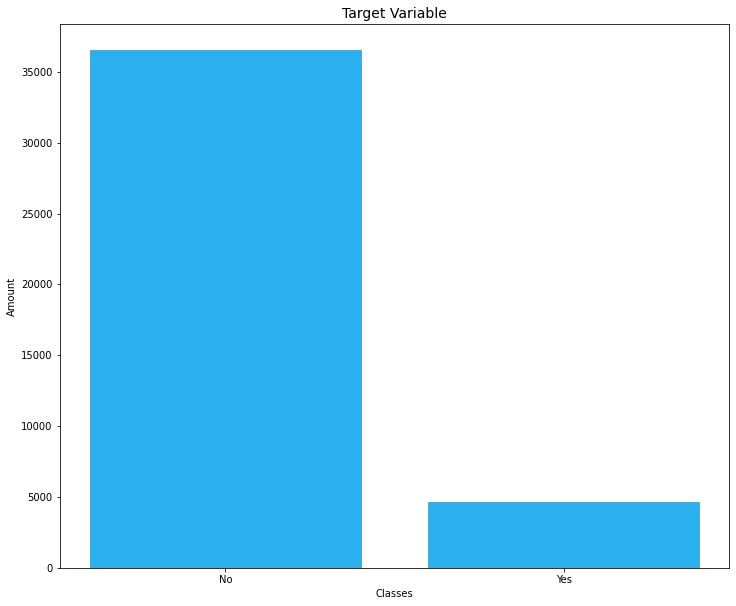

In [ ]:
plt.bar(['No', 'Yes'], bank.y.value_counts().values, facecolor = '#2ab0ee', edgecolor='#167aaa', linewidth=0.5)
plt.title('Target Variable', fontsize=14)
plt.xlabel('Classes')
plt.ylabel('Amount')
plt.show()

Nous constatons clairement sur le graphe que la classe "Yes" est minoritaire.

In [ ]:
#Converting dependent variable categorical to dummy
y = pd.get_dummies(bank['y'], columns = ['y'], drop_first = True)
yA = y

In [ ]:
#pourcentage of minority
print('La classe NO représente', round(bank.y.value_counts().values[0]/bank.shape[0] * 100),'% des données')
print('La classe YES représente', round(bank.y.value_counts().values[1]/bank.shape[0] * 100),'% des données')

La variable **"Y"** est extrêmement déséquilibrée (89% contre 11%). Il est important de fixer cela avant d'appliquer aucune approche ML ou DL, car nous pouvons faire des prédictions avec une précision d'environ 90 % rien qu'avec une True négatif. Comme nous nous concentrons uniquement sur les clients qui ont dit "**Yes**", les chances d'obtenir des prédictions correctes sont très peu.



In [ ]:
# Previos Campaign
plt.bar(['Failure', 'Success'], [sum(bank.poutcome=='failure'), sum(bank.poutcome=='success')], \
        facecolor = '#2ab0ee', edgecolor='#167aaa', linewidth=0.5)
plt.title('Previous Campaign', fontsize=14)
plt.xlabel('Classes')
plt.ylabel('Amount')
plt.show()

In [ ]:
#Returned clients that subscribed to the new term deposit
returned_customers = len(bank[(bank.poutcome=='success') & (bank.y==1)])/len(bank[bank.poutcome=='success'])
print('Clients qui ont souscrit à nouveau un dépôt à terme: {}%'.format(round(returned_customers*100)))

Euribor est l'abréviation de Euro Interbank Offered Rate. Les taux Euribor sont basés sur les taux d'intérêt moyens auxquels un large panel de banques européennes s'empruntent des fonds. Il existe différentes échéances, allant d'une semaine à un an. Les taux Euribor sont considérés comme les taux de référence les plus importants sur le marché monétaire européen.

In [ ]:
# Euribor
plt.bar(['Failure', 'Success'], [bank[bank.poutcome=='failure'].euribor3m.mean(), bank[bank.poutcome=='success'].euribor3m.mean()], \
        facecolor = '#2ab0ee', edgecolor='#167aaa', linewidth=0.5)
plt.title('Euribor', fontsize=14)
plt.xlabel('Classes')
plt.ylabel('Mean Rate')
plt.show()

Avec un taux plus faible on a plus de chance d'avoir un client 

In [ ]:
# Mean Euribor for subscribed/not subscribed client
euribor_1 = bank[bank.y==1].euribor3m.mean()
euribor_0 = bank[bank.y==0].euribor3m.mean()

print('Moyenne Euribor quand le client a dit "Yes":', round(euribor_1, 2))
print('Moyenne Euribor quand le client a dit "No":', round(euribor_0, 2))

In [ ]:
#Marital Status Distribution
plt.figure(figsize=(16,6))
plt.bar(bank.marital.value_counts().keys(), bank.marital.value_counts().values, label='Marital')
plt.bar(bank.marital.value_counts().keys(), [bank[bank.marital==i].y.sum() for i in bank.marital.value_counts().keys()], label='Subscribed')
plt.title('Marital', fontsize=14)
plt.xlabel('Marital')
plt.ylabel('Amount')
plt.legend()
plt.show()

In [ ]:
# infos sur les status 
married = bank[bank.marital=='married'].y.sum()/len(bank[bank.marital=='married'])
single = bank[bank.marital=='single'].y.sum()/len(bank[bank.marital=='single'])

print('Married clients campaign success rate: {0:.0f}%'.format(married*100))
print('Single clients campaign success rate: {0:.0f}%'.format(single*100))

Même si nous avons beaucoup plus de clients qui sont mariés, les clients célibataires ont mieux répondu à la campagne



## Pré-traitements des données

**Analyse et traitement catégorique des données [1/4]**


Nous allons créer un dataframe contenant juste les 7 premières colonnes 

In [ ]:
bank_client = bank.iloc[: , 0:7]
bank_client.head()

,age,job,marital,education,default,housing,loan
0,56,housemaid,married,basic.4y,no,no,no
1,57,services,married,high.school,unknown,no,no
2,37,services,married,high.school,no,yes,no
3,40,admin.,married,basic.6y,no,no,no
4,56,services,married,high.school,no,no,yes


**Convertir les colonnes en des variables continues**


In [ ]:
# Label encoder order is alphabetical
from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
bank_client['job']      = labelencoder_X.fit_transform(bank_client['job']) 
bank_client['marital']  = labelencoder_X.fit_transform(bank_client['marital']) 
bank_client['education']= labelencoder_X.fit_transform(bank_client['education']) 
bank_client['default']  = labelencoder_X.fit_transform(bank_client['default']) 
bank_client['housing']  = labelencoder_X.fit_transform(bank_client['housing']) 
bank_client['loan']     = labelencoder_X.fit_transform(bank_client['loan']) 

In [ ]:
#function to creat group of ages, this helps because we have 78 differente values here
def age(dataframe):
    dataframe.loc[dataframe['age'] <= 32, 'age'] = 1
    dataframe.loc[(dataframe['age'] > 32) & (dataframe['age'] <= 47), 'age'] = 2
    dataframe.loc[(dataframe['age'] > 47) & (dataframe['age'] <= 70), 'age'] = 3
    dataframe.loc[(dataframe['age'] > 70) & (dataframe['age'] <= 98), 'age'] = 4
           
    return dataframe

age(bank_client)

In [ ]:
bank_client.head()

**En rapport avec le dernier contact de la campagne actuelle [2/4]**

In [ ]:
# Trancher le DataFrame pour le traiter séparément, rendre les choses plus faciles
bank_related = bank.iloc[: , 7:11]
bank_related.head()

**Convertir les colonnes en des variables continues**

In [ ]:
# Label encoder order is alphabetical
labelencoder_X = LabelEncoder()
bank_related['contact']     = labelencoder_X.fit_transform(bank_related['contact']) 
bank_related['month']       = labelencoder_X.fit_transform(bank_related['month']) 
bank_related['day_of_week'] = labelencoder_X.fit_transform(bank_related['day_of_week']) 

In [ ]:
bank_related.head()

**Attributs socials et économiques [3/4]**

In [ ]:
bank_se = bank.loc[: , ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']]
bank_se.head()

**Le reste des attributes [4/4]**

In [ ]:
bank_o = bank.loc[: , ['pdays','previous', 'poutcome']]
bank_o.head()

In [ ]:
bank_o['poutcome'].replace(['nonexistent', 'failure', 'success'], [1,2,3], inplace  = True)


# Données de Train, Test et Validation



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import resample

In [ ]:
bank_final= pd.concat([bank_client, bank_related, bank_se, bank_o], axis = 1)
bank_final = bank_final[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
                     'contact', 'month', 'day_of_week', 'emp.var.rate', 'cons.price.idx', 
                     'cons.conf.idx', 'euribor3m', 'nr.employed', 'pdays', 'previous', 'poutcome']]
bank_final['yes'] = bank['y']
bank_final.shape

(41188, 20)

In [ ]:
bank_final.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pdays,pdays,previous,poutcome,yes
0,3,3,1,0,0,0,0,1,6,1,1.1,93.994,-36.4,4.857,5191.0,999,999,0,1,0
1,3,7,1,3,1,0,0,1,6,1,1.1,93.994,-36.4,4.857,5191.0,999,999,0,1,0
2,2,7,1,3,0,2,0,1,6,1,1.1,93.994,-36.4,4.857,5191.0,999,999,0,1,0
3,2,0,1,1,0,0,0,1,6,1,1.1,93.994,-36.4,4.857,5191.0,999,999,0,1,0
4,3,7,1,3,0,0,2,1,6,1,1.1,93.994,-36.4,4.857,5191.0,999,999,0,1,0


In [ ]:
# Classe majoritaire et minoritaire
df_maj = bank_final[bank_final['yes'] == 0]
df_min = bank_final[bank_final['yes'] == 1]
y_new = bank_final['yes']

In [ ]:
# Split données train, test
X_train, X_test, y_train, y_test = train_test_split(bank_final.drop('yes', axis = 1), y_new, test_size = 0.2, random_state = 101)
# Validation Dataset
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size = 0.2)

In [ ]:
#StandardScaler
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
X_val = sc_X.transform(X_val)

Normaliser les entités d'entrée à l'aide de sklearn StandardScaler. Cela définira la moyenne sur 0 et l'écart type sur 1.

In [ ]:
print('Training dataset shape est',X_train.shape,'soit',round(X_train.shape[0]/bank_final.shape[0]*100),'% des données')
print('Testing dataset shape est ',X_test.shape,'soit',round(X_test.shape[0]/bank_final.shape[0]*100),'% des données')
print('Validation dataset shape est ',X_val.shape,'soit',round(X_val.shape[0]/bank_final.shape[0]*100),'% des données')

Training dataset shape est (26360, 19) soit 64 % des données
Testing dataset shape est  (8238, 19) soit 20 % des données
Validation dataset shape est  (6590, 19) soit 16 % des données


# Entrainement simple

## Entrainement d'un modèle Deep baseline

Création et entraînement de notre modèle à l'aide de la fonction définie précédemment. Le modèle est adapté en utilisant une taille de lot plus grande que la taille par défaut de 150, ceci est important pour s'assurer que chaque lot a une chance décente de contenir quelques échantillons positifs. Si la taille du lot était trop petite, ils n'auraient probablement aucune transaction true positif à tirer.



In [ ]:
# Metrics 
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# Baseline Modèle
def make_model_baseline(metrics=METRICS, output_bias=None):
  seed(100)
  tf.random.set_seed(100)
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

## Baseline modèle

In [ ]:
# Parametres
EPOCHS = 200
BATCH_SIZE = 2000

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

In [ ]:
# Modèle baseline
model_baseline = make_model_baseline()
model_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                320       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_baseline.predict(X_train[:10])

array([[0.14064652],
       [0.11714789],
       [0.35949925],
       [0.25203168],
       [0.3495723 ],
       [0.15870571],
       [0.26533434],
       [0.09104085],
       [0.23780748],
       [0.22125116]], dtype=float32)

**Avec l'initialisation du biais par défaut**

In [ ]:
results = model_baseline.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4775


**Le biais correct à définir peut être dérivé**



In [ ]:
# neg et pos classe
neg, pos = np.bincount(bank_final['yes'])

In [ ]:
# Le biais
initial_bias = np.log([pos/neg])
initial_bias

array([-2.0639121])

In [ ]:
model = make_model_baseline(output_bias=initial_bias)
model.predict(X_train[:10])

array([[0.07302088],
       [0.06003156],
       [0.21268886],
       [0.13954663],
       [0.20551512],
       [0.08323795],
       [0.14808759],
       [0.0459902 ],
       [0.1305627 ],
       [0.12029445]], dtype=float32)

In [ ]:
# doit etre proche à p0
p0 = pos/(pos+neg)
p0

0.11265417111780131

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.352$$

In [ ]:
-p0*np.log(p0)-(1-p0)*np.log(1-p0)

0.35202879341950966

In [ ]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4086


Pour rendre les différentes exécutions d'entraînement plus comparables, nous allons conserver les pondérations de ce modèle initial dans un fichier de point de contrôle et chargons-les dans chaque modèle avant l'entraînement.




In [ ]:
initial_weights_baseline = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights_baseline)

In [ ]:
# Sans biais 
model = make_model_baseline()
model.load_weights(initial_weights_baseline)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0)

In [ ]:
# Avec biais 
model = make_model_baseline()
model.load_weights(initial_weights_baseline)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0)

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

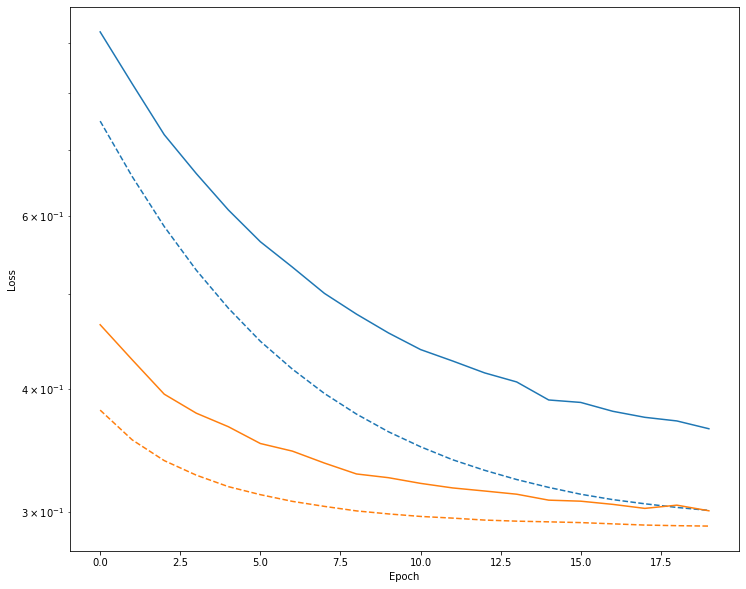

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

La figure ci-dessus le précise: en termes de perte de validation, sur ce problème, cette initialisation soigneuse donne un net avantage.

## Train Baseline modèle

In [ ]:
def fit_model(model, init_weights, class_weight = None,X_train = X_train,y_train = y_train):

  model.load_weights(init_weights)
  if  class_weight is not None:
    model_history = model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[early_stopping],validation_data=(X_val, y_val),class_weight=class_weight)
  
  else:
    model_history = model.fit(
      X_train,
      y_train,  
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      callbacks=[early_stopping],
      validation_data=(X_val, y_val))
  return model_history, model

In [ ]:
def evaluate_model(model):
  # Evaluations
  test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)
  results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
  for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
    if name == 'accuracy':
      accur = value
    elif name == 'precision':
      prec = value
    elif name == 'recall':
      rec = value
    elif name == 'auc':
      auc = value    

  # Matrice de confusion
  plot_cm(y_test, test_predictions)
  
  return accur, prec, rec, auc

In [ ]:
# Train Basline model
model_baseline = make_model_baseline(output_bias = initial_bias)
model_history, model = fit_model(model_baseline,initial_weights_baseline)

Epoch 1/200
14/14 [==============================] - 3s 79ms/step - loss: 0.4745 - tp: 308.2667 - fp: 640.7333 - tn: 19109.9333 - fn: 2179.0667 - accuracy: 0.8746 - precision: 0.3442 - recall: 0.1273 - auc: 0.5755 - val_loss: 0.3811 - val_tp: 27.0000 - val_fp: 45.0000 - val_tn: 5788.0000 - val_fn: 730.0000 - val_accuracy: 0.8824 - val_precision: 0.3750 - val_recall: 0.0357 - val_auc: 0.4967
Epoch 2/200
14/14 [==============================] - 0s 13ms/step - loss: 0.4308 - tp: 194.4667 - fp: 446.0667 - tn: 13480.2667 - fn: 1527.2000 - accuracy: 0.8732 - precision: 0.2937 - recall: 0.1109 - auc: 0.5152 - val_loss: 0.3555 - val_tp: 53.0000 - val_fp: 39.0000 - val_tn: 5794.0000 - val_fn: 704.0000 - val_accuracy: 0.8873 - val_precision: 0.5761 - val_recall: 0.0700 - val_auc: 0.5687
Epoch 3/200
14/14 [==============================] - 0s 13ms/step - loss: 0.4007 - tp: 208.8667 - fp: 359.4000 - tn: 13532.6667 - fn: 1547.0667 - accuracy: 0.8784 - precision: 0.3735 - recall: 0.1196 - auc: 0.560

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([0,1.05])
  plt.ylim([0,1.01])
  plt.grid(True)
  ax = plt.gca()
  ax.plot([0, 1], [0, 1],'r--')
  ax.set_aspect('equal')

In [ ]:
def roc(model):
  #prédictions
  train_predictions = model.predict(X_train, batch_size=BATCH_SIZE)
  test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)
  # roc 
  plot_roc("Train", y_train, train_predictions, color=colors[0])
  plot_roc("Test", y_test, test_predictions, color=colors[0], linestyle='--')
  plt.legend(loc='lower right')

## Évaluer les métriques

Évaluation de notre modèle sur l'ensemble de données de test

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.7,1])
    else:
      plt.ylim([0,1])

    plt.legend()



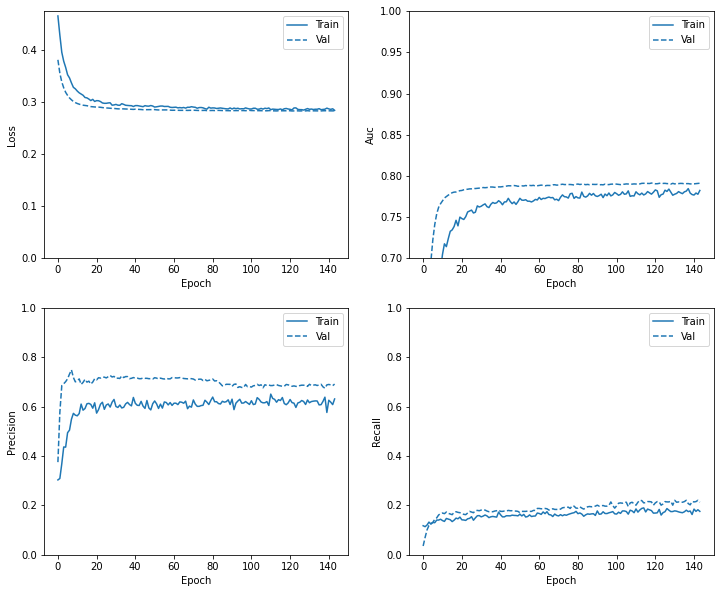

In [ ]:
plot_metrics(model_history)

In [ ]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d",cmap=plt.cm.Blues)
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('The client correctly predicted not to subscribe to a term deposit (True Negatives): ', cm[0][0])
  print('The client Incorrectly predicted subscribed a term deposit(False Positives): ', cm[0][1])
  print('The client mistakenly predicted not subscribed a term deposit (False Negatives): ', cm[1][0])
  print('The client correctly predicted subscribed a term deposit(True Positives): ', cm[1][1])

loss :  0.28888365626335144
tp :  183.0
fp :  67.0
tn :  7212.0
fn :  776.0
accuracy :  0.8976693153381348
precision :  0.7319999933242798
recall :  0.1908237785100937
auc :  0.7762874364852905
The client correctly predicted not to subscribe to a term deposit (True Negatives):  7212
The client Incorrectly predicted subscribed a term deposit(False Positives):  67
The client mistakenly predicted not subscribed a term deposit (False Negatives):  776
The client correctly predicted subscribed a term deposit(True Positives):  183


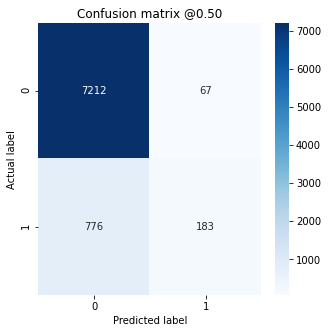

In [ ]:
# evaluation baseline
baseline_simple_acc,baseline_simple_precision, baseline_simple_recall, baseline_simple_auc =  evaluate_model(model)


1.   Les faux positifs sont plus préjudiciables, car nous pensons que nous avons déjà ce client mais que nous ne l'avons pas et que nous l'avons peut-être perdu lors des prochaines campagnes.

2.   Les faux négatifs ne sont pas bonnes mais tolérables, on contate que nous avons ce client mais plutard nous découvrirons qu'en vérité il est déjà notre client




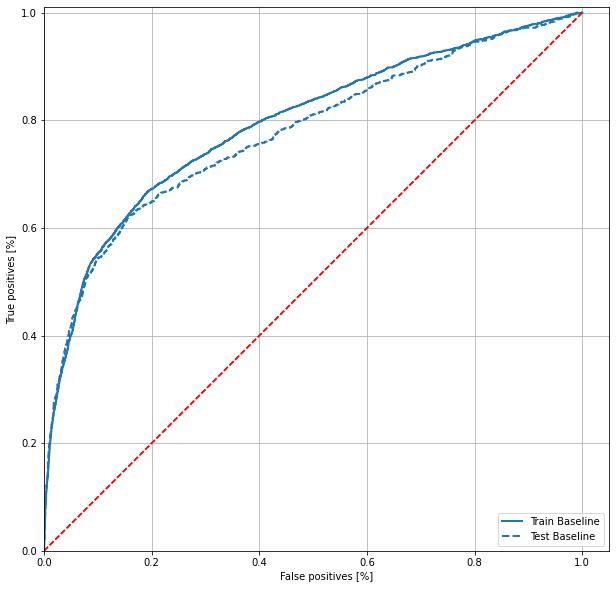

In [ ]:
plot_roc("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

la courbe de validation fonctionne généralement mieux que la courbe d'apprentissage. Ceci est principalement dû au fait que la couche de dropout n'est pas active lors de l'évaluation du modèle.


## Modèle plus élaboré


In [ ]:
# Modèle plus élaboré
def make_model_elabore(metrics=METRICS, output_bias=None):
  seed(100)
  tf.random.set_seed(100)
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(X_train.shape[-1],)), 
      keras.layers.Dense(25, activation='relu'),
      keras.layers.Dense(25, activation='relu'),
      keras.layers.Dense(25, activation='relu'),
      keras.layers.Dense(25, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.D  8.0ense(1, activation='sigmoid',bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model


Le modèle élaboré conçu pour ce type de jeu donnée:

La structure et l'architecture du réseau proposé consiste en 5 couches cachées(hidden layers) avec ReLu comme fonction d'activation et qui interconnectent les couches d'entrée (input) et de sortie(output). Chaque couche cachée accueille en interne 25 nœuds et une 16 nœuds . La taille de la couche d'entrée (inp) est égale au nombre de caractéristiques qu'on a garder à partir de la partie pré-traitment. Comme le label de classe est un attribut binaire, la taille de la couche de sortie (out) est de un avec une fonction d'activation sigmoid, où le nœud indique l'une des deux valeurs (oui/non).
Donc, la taille totale du réseau de neurones est inp*(25*4 +16)*out



In [ ]:
# Modèle baseline
model_elab = make_model_elabore()
model_elab.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 19)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 25)                500       
_________________________________________________________________
dense_11 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_12 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_13 (Dense)             (None, 25)                650       
_________________________________________________________________
dropout_5 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)               

In [ ]:
results = model_elab.evaluate(X_train, y_train, batch_size=100, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4159


In [ ]:
model_elab = make_model_elabore(output_bias=initial_bias)
model.predict(X_train[:10])

array([[0.15853965],
       [0.03710768],
       [0.05875152],
       [0.03320882],
       [0.05625775],
       [0.4299732 ],
       [0.04678395],
       [0.03379545],
       [0.04231709],
       [0.11530292]], dtype=float32)

In [ ]:
results = model_elab.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3523


In [ ]:
initial_weights_elab = os.path.join(tempfile.mkdtemp(), 'initial_weights_elab')
model_elab.save_weights(initial_weights_elab)

In [ ]:
# Train Elaborated model
model_elab = make_model_elabore(output_bias = initial_bias)
model_history, model = fit_model(model_elab,initial_weights_elab)

Epoch 1/200
14/14 [==============================] - 3s 80ms/step - loss: 0.3511 - tp: 183.0000 - fp: 67.0000 - tn: 68001.6667 - fn: 8354.3333 - accuracy: 0.8901 - precision: 0.7320 - recall: 0.0217 - auc: 0.5191 - val_loss: 0.3527 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5833.0000 - val_fn: 757.0000 - val_accuracy: 0.8851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6557
Epoch 2/200
14/14 [==============================] - 0s 17ms/step - loss: 0.3398 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 13926.3333 - fn: 1721.6667 - accuracy: 0.8904 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6370 - val_loss: 0.3421 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5833.0000 - val_fn: 757.0000 - val_accuracy: 0.8851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7192
Epoch 3/200
14/14 [==============================] - 0s 17ms/step - loss: 0.3329 - tp: 2.6000 - fp: 0.6667 - tn: 13891.4000 - fn: 1753.3333 - accuracy: 0.8876 - precision: 0

loss :  0.29221105575561523
tp :  115.0
fp :  43.0
tn :  7236.0
fn :  844.0
accuracy :  0.8923282623291016
precision :  0.7278481125831604
recall :  0.11991658061742783
auc :  0.7735373973846436
The client correctly predicted not to subscribe to a term deposit (True Negatives):  7236
The client Incorrectly predicted subscribed a term deposit(False Positives):  43
The client mistakenly predicted not subscribed a term deposit (False Negatives):  844
The client correctly predicted subscribed a term deposit(True Positives):  115


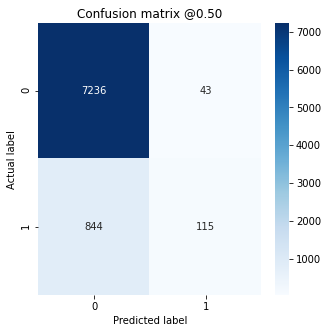

In [ ]:
x

In [ ]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

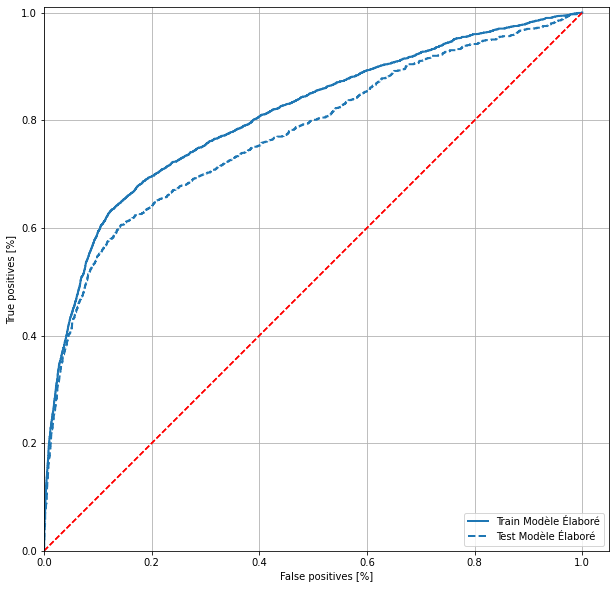

In [ ]:
plot_roc("Train Modèle Élaboré", y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Modèle Élaboré", y_test, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

## **Interprétation:**
Nous constatons clairement que la zone sous ROC n'est pas bonne autour de 0. nous pouvons voir également que nous avons un recall très faible.
À partir de cette première étude, nous pourrons dire que notre modèle de baseline n'est pas une bonne solution pour ce type de données déséquilibrées. Bien sûr, il est important d'examiner les coûts dans notre modèle de base, car nous avons beaucoup de FALSE NÉGATIF (le client est prédit à tort qu'il ne souscrirait pas à un dépôt à terme), cependant, avoir des FALSE POSITIF peut entraîner des pertes de clients dans les campagnes futures.

En revanche de point de vue précision(les vrais positifs biens classés) notre modèle élaboré performe mieux 73% sur les données de base (aucune modifications sur les données jusqu'à présent).




Nous allons, par la suite, créer deux fonctions *baseline* et *modele_elabore* pour les prochaines utilisations de notre deux modèles afin de les entrainer et évaluer leurs résultats.

In [ ]:
def basline(X_train = X_train, y_train = y_train):
  seed(100)
  model_baseline = make_model_baseline(output_bias=initial_bias)
  # Poid modèle élaboré
  initial_weights_baseline = os.path.join(tempfile.mkdtemp(), 'initial_weights_baseline')
  model_baseline.save_weights(initial_weights_baseline)
  model_history, model = fit_model(model_baseline,initial_weights_baseline,X_train = X_train, y_train = y_train)
  print(100*'-')
  plot_metrics(model_history)
  return model

def modele_elabore(X_train = X_train, y_train = y_train):
  seed(100)
  model_elabore = make_model_elabore(output_bias=initial_bias)
  # Poid modèle élaboré
  initial_weights_elab = os.path.join(tempfile.mkdtemp(), 'initial_weights_elab')
  model_elabore.save_weights(initial_weights_elab)
  model_history, model = fit_model(model_elabore,initial_weights_elab,X_train = X_train, y_train = y_train)
  print(100*'-')
  plot_metrics(model_history)
  return model


# Entrainement avec pondération des classes

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of= ne the weights of all examples stays the same.
total = pos + neg
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.56
Weight for class 1: 4.44


## Entrainement Baseline

In [ ]:
# baseline
weighted_model = make_model_baseline(output_bias=initial_bias)
model_history, model = fit_model(weighted_model,initial_weights_baseline, class_weight)


Epoch 1/200
14/14 [==============================] - 3s 72ms/step - loss: 1.3025 - tp: 327.1333 - fp: 762.3333 - tn: 20434.3333 - fn: 2362.2000 - accuracy: 0.8711 - precision: 0.3250 - recall: 0.1201 - auc: 0.5919 - val_loss: 0.3933 - val_tp: 63.0000 - val_fp: 96.0000 - val_tn: 5737.0000 - val_fn: 694.0000 - val_accuracy: 0.8801 - val_precision: 0.3962 - val_recall: 0.0832 - val_auc: 0.5095
Epoch 2/200
14/14 [==============================] - 0s 13ms/step - loss: 1.1079 - tp: 292.0667 - fp: 952.9333 - tn: 12973.4000 - fn: 1429.6000 - accuracy: 0.8484 - precision: 0.2305 - recall: 0.1639 - auc: 0.5243 - val_loss: 0.3907 - val_tp: 129.0000 - val_fp: 177.0000 - val_tn: 5656.0000 - val_fn: 628.0000 - val_accuracy: 0.8778 - val_precision: 0.4216 - val_recall: 0.1704 - val_auc: 0.5919
Epoch 3/200
14/14 [==============================] - 0s 13ms/step - loss: 0.9882 - tp: 420.6000 - fp: 1278.3333 - tn: 12613.7333 - fn: 1335.3333 - accuracy: 0.8347 - precision: 0.2517 - recall: 0.2377 - auc: 0.

## Vérifier l'historique d'entraînement

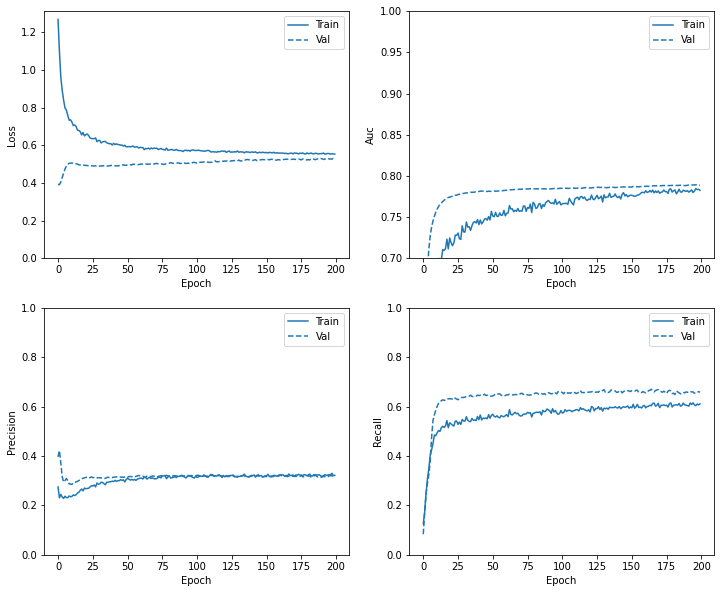

In [ ]:
# historique
plot_metrics(model_history)

loss :  0.5210938453674316
tp :  592.0
fp :  1239.0
tn :  6040.0
fn :  367.0
accuracy :  0.8050497770309448
precision :  0.323320597410202
recall :  0.6173096895217896
auc :  0.7723901271820068
The client correctly predicted not to subscribe to a term deposit (True Negatives):  6040
The client Incorrectly predicted subscribed a term deposit(False Positives):  1239
The client mistakenly predicted not subscribed a term deposit (False Negatives):  367
The client correctly predicted subscribed a term deposit(True Positives):  592


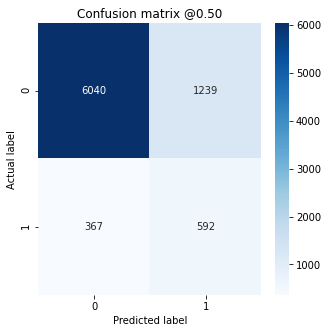

In [ ]:
# Matrice de confusion
baseline_pond_acc,baseline_pond_precision,baseline_pond_recall,baseline_pond_auc  = evaluate_model(model)

## Modèle élaboré

In [ ]:
# modèle élaboré
weighted_model_el = make_model_elabore(output_bias=initial_bias)
model_history, model = fit_model(weighted_model_el,initial_weights_elab, class_weight)


Epoch 1/200
14/14 [==============================] - 3s 78ms/step - loss: 1.0798 - tp: 592.0000 - fp: 1241.4000 - tn: 19955.2667 - fn: 2097.3333 - accuracy: 0.8557 - precision: 0.3229 - recall: 0.2530 - auc: 0.5312 - val_loss: 0.3854 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5833.0000 - val_fn: 757.0000 - val_accuracy: 0.8851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4193
Epoch 2/200
14/14 [==============================] - 0s 16ms/step - loss: 0.9192 - tp: 40.4000 - fp: 410.0667 - tn: 13516.2667 - fn: 1681.2667 - accuracy: 0.8721 - precision: 0.0664 - recall: 0.0165 - auc: 0.4746 - val_loss: 0.4632 - val_tp: 46.0000 - val_fp: 116.0000 - val_tn: 5717.0000 - val_fn: 711.0000 - val_accuracy: 0.8745 - val_precision: 0.2840 - val_recall: 0.0608 - val_auc: 0.5420
Epoch 3/200
14/14 [==============================] - 0s 16ms/step - loss: 0.7562 - tp: 490.6000 - fp: 2551.0667 - tn: 11341.0000 - fn: 1265.3333 - accuracy: 0.7655 - precision: 0.1566 - recall: 0.2

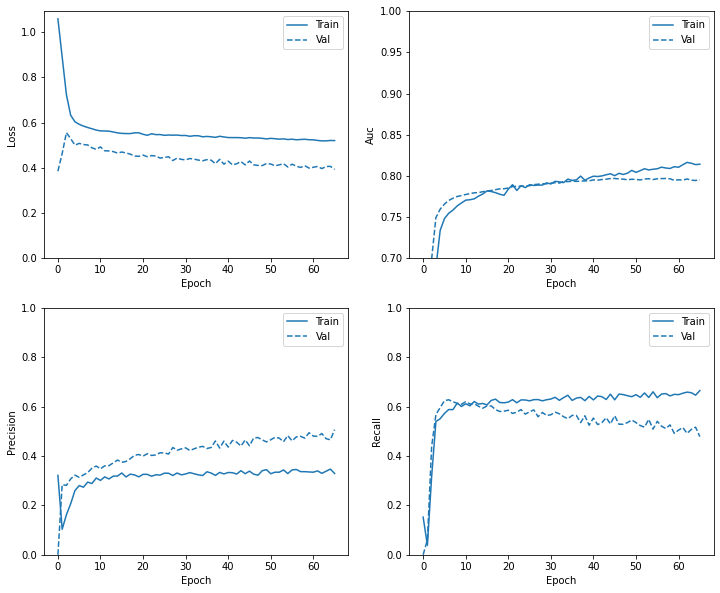

In [ ]:
# Afficher les metrics
plot_metrics(model_history)

loss :  0.4270951449871063
tp :  514.0
fp :  656.0
tn :  6623.0
fn :  445.0
accuracy :  0.8663510680198669
precision :  0.4393162429332733
recall :  0.5359749794006348
auc :  0.778336763381958
The client correctly predicted not to subscribe to a term deposit (True Negatives):  6623
The client Incorrectly predicted subscribed a term deposit(False Positives):  656
The client mistakenly predicted not subscribed a term deposit (False Negatives):  445
The client correctly predicted subscribed a term deposit(True Positives):  514


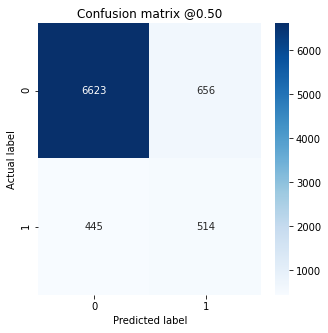

In [ ]:
# Matrice de confusion
model_ela_pond_acc,model_ela_pond_precision,model_ela_pond_recall,model_ela_pond_auc  = evaluate_model(model)


## Interpretation


Par rapport à notre modèle de base, notre modèle élaboré a pu réduire l'erreur de 10 %,

Comme nous souhaitons réduire notre FP, le modèle développé a réduit les FP de plus de 50 %, ce qui augmente légèrement par conséquent la précision de notre modèle. Cela est pratiquement dû au fait que la pondération avec les poids de chaque classe a un impact positif sur le rappel (les vrais positifs qui ont été correctement classés).

# Entrainement avec oversampling

## Random oversampling

Le oversampling peut être défini comme l'ajout de copies supplémentaires à la classe minoritaire.

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Random OverSampling 
ros =  RandomOverSampler()
X_train_new,y_train_new = ros.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original dataset shape Counter({0: 23436, 1: 2924})
Resampled dataset shape Counter({0: 23436, 1: 23436})


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


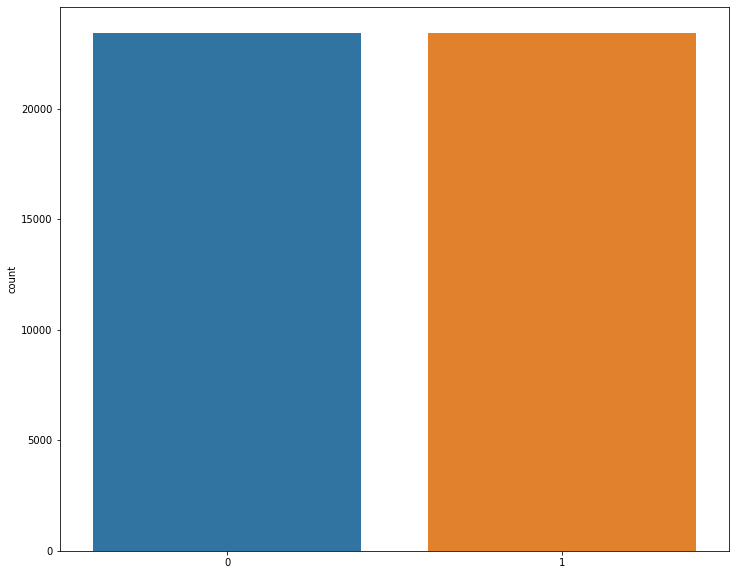

In [ ]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_train_new)))
sns.countplot(y_train_new)

Nous constatons que avec oversampling les classes sont devenues équilibrées.

## Entrainement Baseline

Epoch 1/200
24/24 [==============================] - 3s 47ms/step - loss: 1.2744 - tp: 2218.9600 - fp: 1395.9600 - tn: 18808.2400 - fn: 11644.6000 - accuracy: 0.6378 - precision: 0.5942 - recall: 0.1716 - auc: 0.4431 - val_loss: 0.3900 - val_tp: 115.0000 - val_fp: 158.0000 - val_tn: 5675.0000 - val_fn: 642.0000 - val_accuracy: 0.8786 - val_precision: 0.4212 - val_recall: 0.1519 - val_auc: 0.5757
Epoch 2/200
24/24 [==============================] - 0s 12ms/step - loss: 1.0157 - tp: 3009.0800 - fp: 1270.8400 - tn: 11635.7200 - fn: 9914.1200 - accuracy: 0.5643 - precision: 0.7021 - recall: 0.2242 - auc: 0.5569 - val_loss: 0.4221 - val_tp: 205.0000 - val_fp: 409.0000 - val_tn: 5424.0000 - val_fn: 552.0000 - val_accuracy: 0.8542 - val_precision: 0.3339 - val_recall: 0.2708 - val_auc: 0.6721
Epoch 3/200
24/24 [==============================] - 0s 11ms/step - loss: 0.8627 - tp: 4364.4400 - fp: 1830.2800 - tn: 11126.2000 - fn: 8508.8400 - accuracy: 0.5994 - precision: 0.7050 - recall: 0.3339 -

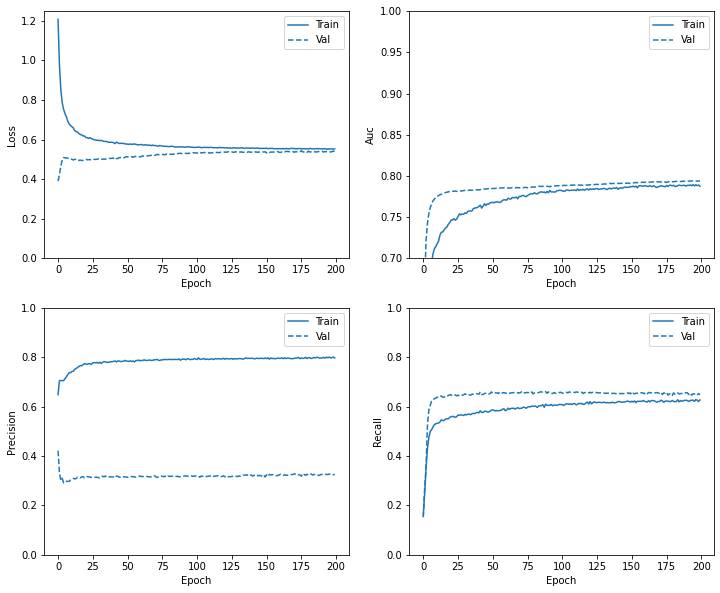

In [ ]:
# baseline
modele_baseline = basline(X_train = X_train_new, y_train = y_train_new)

loss :  0.5291345119476318
tp :  595.0
fp :  1190.0
tn :  6089.0
fn :  364.0
accuracy :  0.8113619685173035
precision :  0.3333333432674408
recall :  0.6204379796981812
auc :  0.7801693081855774
The client correctly predicted not to subscribe to a term deposit (True Negatives):  6089
The client Incorrectly predicted subscribed a term deposit(False Positives):  1190
The client mistakenly predicted not subscribed a term deposit (False Negatives):  364
The client correctly predicted subscribed a term deposit(True Positives):  595


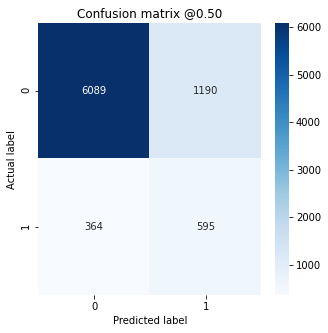

In [ ]:
# Evaluation
baseline_random_oversampling_acc,baseline_random_oversampling_precision,baseline_random_oversampling_recall,baseline_random_oversampling_auc  = evaluate_model(modele_baseline)

## Modèle Élaboré

Epoch 1/200
24/24 [==============================] - 3s 53ms/step - loss: 1.0656 - tp: 630.4400 - fp: 1254.4000 - tn: 18949.8000 - fn: 13233.1200 - accuracy: 0.5953 - precision: 0.3343 - recall: 0.0704 - auc: 0.3419 - val_loss: 0.4424 - val_tp: 3.0000 - val_fp: 35.0000 - val_tn: 5798.0000 - val_fn: 754.0000 - val_accuracy: 0.8803 - val_precision: 0.0789 - val_recall: 0.0040 - val_auc: 0.5088
Epoch 2/200
24/24 [==============================] - 0s 14ms/step - loss: 0.7668 - tp: 3766.8800 - fp: 2487.0000 - tn: 10419.5600 - fn: 9156.3200 - accuracy: 0.5365 - precision: 0.5784 - recall: 0.2402 - auc: 0.5494 - val_loss: 0.5663 - val_tp: 431.0000 - val_fp: 1133.0000 - val_tn: 4700.0000 - val_fn: 326.0000 - val_accuracy: 0.7786 - val_precision: 0.2756 - val_recall: 0.5694 - val_auc: 0.7395
Epoch 3/200
24/24 [==============================] - 0s 15ms/step - loss: 0.6184 - tp: 7323.3600 - fp: 2848.0400 - tn: 10108.4400 - fn: 5549.9200 - accuracy: 0.6718 - precision: 0.7123 - recall: 0.5706 - au

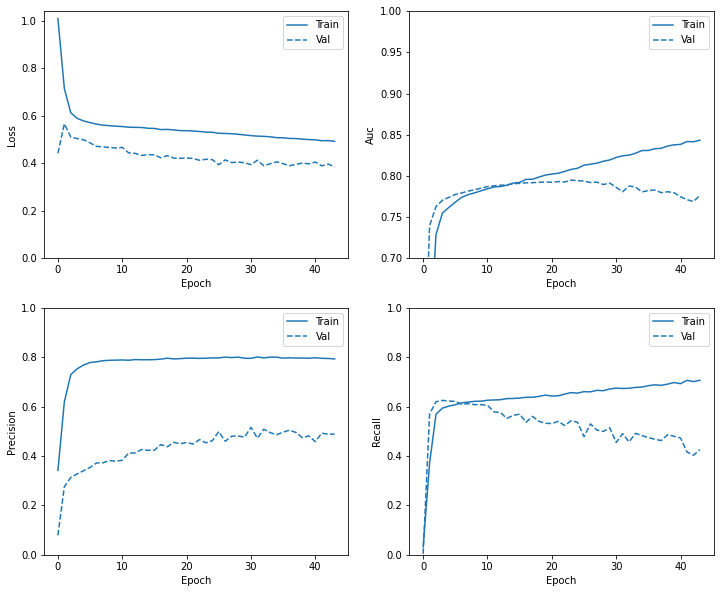

In [ ]:
# model élaboré
modele_elab = modele_elabore(X_train = X_train_new, y_train = y_train_new)

loss :  0.4133312404155731
tp :  503.0
fp :  594.0
tn :  6685.0
fn :  456.0
accuracy :  0.8725419044494629
precision :  0.4585232436656952
recall :  0.5245047211647034
auc :  0.7815815210342407
The client correctly predicted not to subscribe to a term deposit (True Negatives):  6685
The client Incorrectly predicted subscribed a term deposit(False Positives):  594
The client mistakenly predicted not subscribed a term deposit (False Negatives):  456
The client correctly predicted subscribed a term deposit(True Positives):  503


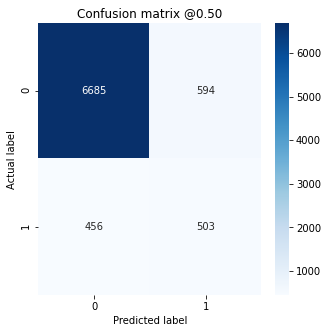

In [ ]:
# Evaluation
model_ela_random_oversampling_acc,model_ela_random_oversampling_precision,model_ela_random_oversampling_recall,model_ela_random_oversampling_auc  = evaluate_model(modele_elab)


## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(0.5)
X_train_new_smote,y_train_new_smote =sm.fit_sample(X_train,y_train)
#X_val_new_smote,y_val_new_smote =sm.fit_sample(X_val,y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Baseline

Epoch 1/200
18/18 [==============================] - 3s 60ms/step - loss: 0.9358 - tp: 1301.7368 - fp: 1258.0000 - tn: 19234.7895 - fn: 6249.1579 - accuracy: 0.7439 - precision: 0.5021 - recall: 0.1906 - auc: 0.4768 - val_loss: 0.3808 - val_tp: 87.0000 - val_fp: 108.0000 - val_tn: 5725.0000 - val_fn: 670.0000 - val_accuracy: 0.8819 - val_precision: 0.4462 - val_recall: 0.1149 - val_auc: 0.5488
Epoch 2/200
18/18 [==============================] - 0s 13ms/step - loss: 0.8126 - tp: 1226.6316 - fp: 912.8947 - tn: 12289.7368 - fn: 5376.4211 - accuracy: 0.6819 - precision: 0.5670 - recall: 0.1807 - auc: 0.5460 - val_loss: 0.3772 - val_tp: 163.0000 - val_fp: 213.0000 - val_tn: 5620.0000 - val_fn: 594.0000 - val_accuracy: 0.8775 - val_precision: 0.4335 - val_recall: 0.2153 - val_auc: 0.6453
Epoch 3/200
18/18 [==============================] - 0s 14ms/step - loss: 0.7374 - tp: 1613.3684 - fp: 1155.9474 - tn: 12065.5263 - fn: 4970.8421 - accuracy: 0.6884 - precision: 0.5756 - recall: 0.2394 - au

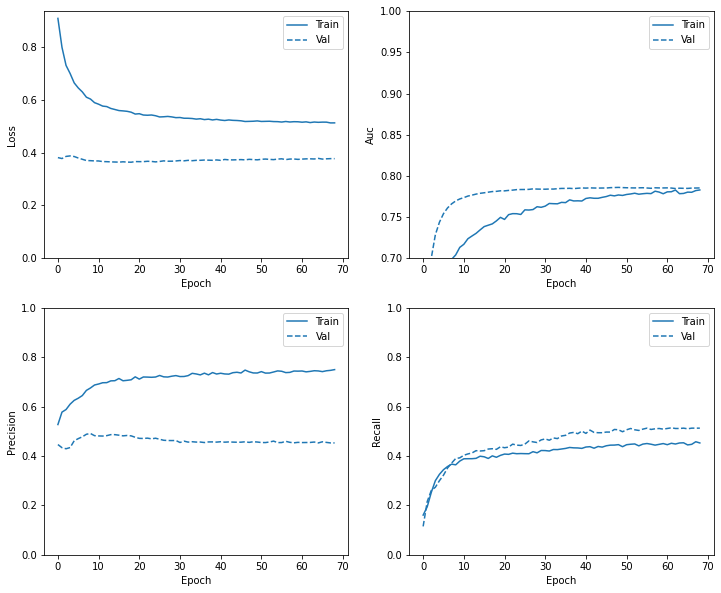

In [ ]:
# Baseline
modele_baseline = basline(X_train = X_train_new_smote, y_train = y_train_new_smote)

loss :  0.36944785714149475
tp :  467.0
fp :  535.0
tn :  6744.0
fn :  492.0
accuracy :  0.875333845615387
precision :  0.4660678505897522
recall :  0.4869655966758728
auc :  0.771614670753479
The client correctly predicted not to subscribe to a term deposit (True Negatives):  6744
The client Incorrectly predicted subscribed a term deposit(False Positives):  535
The client mistakenly predicted not subscribed a term deposit (False Negatives):  492
The client correctly predicted subscribed a term deposit(True Positives):  467


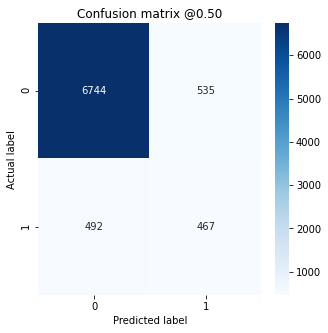

In [ ]:
# Evaluation
baseline_smote_acc,baseline_smote_precision,baseline_smote_recall,baseline_smote_auc  = evaluate_model(modele_baseline)

## Modèle Élaboré

Epoch 1/200
18/18 [==============================] - 3s 65ms/step - loss: 0.7735 - tp: 467.0000 - fp: 536.1579 - tn: 19956.6316 - fn: 7083.8947 - accuracy: 0.7409 - precision: 0.4655 - recall: 0.0878 - auc: 0.4210 - val_loss: 0.3744 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5833.0000 - val_fn: 757.0000 - val_accuracy: 0.8851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5336
Epoch 2/200
18/18 [==============================] - 0s 16ms/step - loss: 0.6621 - tp: 370.1053 - fp: 134.8947 - tn: 13067.7368 - fn: 6232.9474 - accuracy: 0.6761 - precision: 0.7398 - recall: 0.0398 - auc: 0.5593 - val_loss: 0.4124 - val_tp: 204.0000 - val_fp: 197.0000 - val_tn: 5636.0000 - val_fn: 553.0000 - val_accuracy: 0.8862 - val_precision: 0.5087 - val_recall: 0.2695 - val_auc: 0.7232
Epoch 3/200
18/18 [==============================] - 0s 16ms/step - loss: 0.5697 - tp: 2150.8421 - fp: 984.6842 - tn: 12236.7895 - fn: 4433.3684 - accuracy: 0.7231 - precision: 0.6831 - recall: 0.

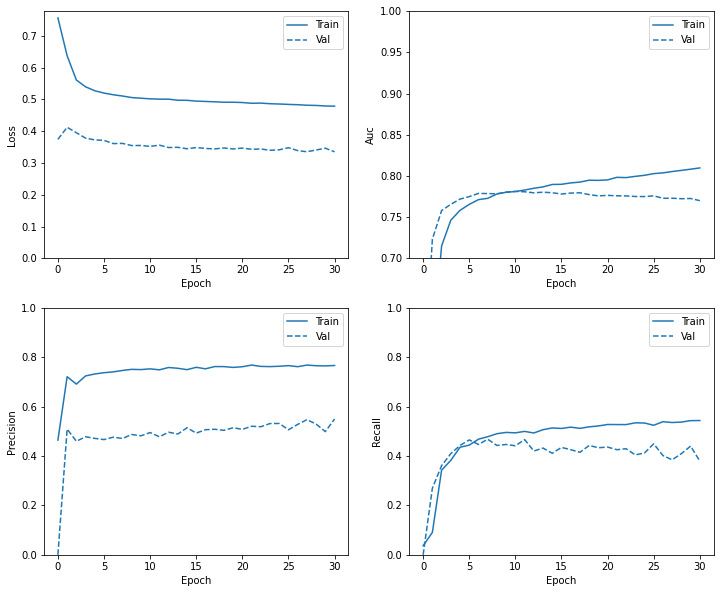

In [ ]:
# modèle élaboré
modele_elab = modele_elabore(X_train = X_train_new_smote, y_train = y_train_new_smote)

loss :  0.35068148374557495
tp :  430.0
fp :  431.0
tn :  6848.0
fn :  529.0
accuracy :  0.8834668397903442
precision :  0.49941927194595337
recall :  0.44838371872901917
auc :  0.7698086500167847
The client correctly predicted not to subscribe to a term deposit (True Negatives):  6848
The client Incorrectly predicted subscribed a term deposit(False Positives):  431
The client mistakenly predicted not subscribed a term deposit (False Negatives):  529
The client correctly predicted subscribed a term deposit(True Positives):  430


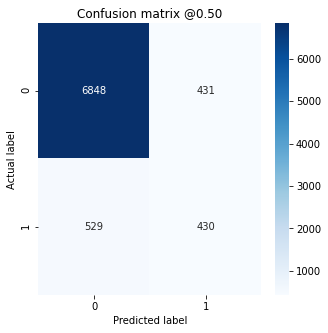

In [ ]:
# Evaluation
model_ela_smote_acc,model_ela_smote_precision,model_ela_smote_recall,model_ela_smote_auc  = evaluate_model(modele_elab)

## ADASYN

In [ ]:
from imblearn.over_sampling import ADASYN

ada= ADASYN(sampling_strategy=0.7)
X_train_new_ada,y_train_new_ada = ada.fit_sample(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Baseline

Epoch 1/200
20/20 [==============================] - 3s 56ms/step - loss: 1.0565 - tp: 1289.5238 - fp: 1148.4286 - tn: 19116.6667 - fn: 8542.2381 - accuracy: 0.6957 - precision: 0.5245 - recall: 0.1453 - auc: 0.4868 - val_loss: 0.3895 - val_tp: 94.0000 - val_fp: 120.0000 - val_tn: 5713.0000 - val_fn: 663.0000 - val_accuracy: 0.8812 - val_precision: 0.4393 - val_recall: 0.1242 - val_auc: 0.5491
Epoch 2/200
20/20 [==============================] - 1s 32ms/step - loss: 0.9283 - tp: 1384.1905 - fp: 1109.8095 - tn: 11865.4762 - fn: 7499.3810 - accuracy: 0.6056 - precision: 0.5506 - recall: 0.1491 - auc: 0.5237 - val_loss: 0.3995 - val_tp: 176.0000 - val_fp: 270.0000 - val_tn: 5563.0000 - val_fn: 581.0000 - val_accuracy: 0.8709 - val_precision: 0.3946 - val_recall: 0.2325 - val_auc: 0.6459
Epoch 3/200
20/20 [==============================] - 0s 13ms/step - loss: 0.8334 - tp: 2061.0476 - fp: 1479.0952 - tn: 11543.3810 - fn: 6775.3333 - accuracy: 0.6252 - precision: 0.5896 - recall: 0.2320 - a

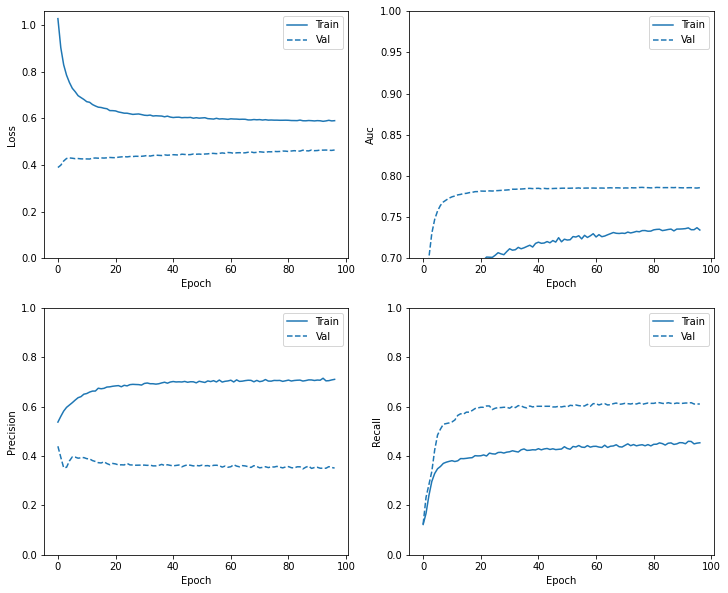

In [ ]:
# Baseline
modele_baseline = basline(X_train = X_train_new_ada, y_train = y_train_new_ada)

loss :  0.4534524083137512
tp :  549.0
fp :  963.0
tn :  6316.0
fn :  410.0
accuracy :  0.8333333134651184
precision :  0.363095223903656
recall :  0.5724713206291199
auc :  0.7682300209999084
The client correctly predicted not to subscribe to a term deposit (True Negatives):  6316
The client Incorrectly predicted subscribed a term deposit(False Positives):  963
The client mistakenly predicted not subscribed a term deposit (False Negatives):  410
The client correctly predicted subscribed a term deposit(True Positives):  549


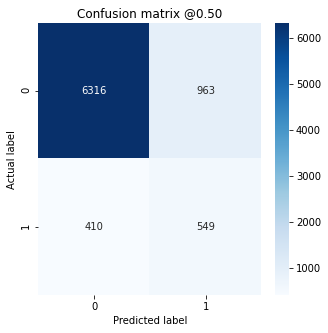

In [ ]:
baseline_adasyn_acc,baseline_adasyn_precision,baseline_adasyn_recall,baseline_adasyn_auc  = evaluate_model(modele_baseline)

## Modèle élaboré

Epoch 1/200
20/20 [==============================] - 3s 58ms/step - loss: 0.9058 - tp: 554.1905 - fp: 981.1429 - tn: 19283.9524 - fn: 9277.5714 - accuracy: 0.6746 - precision: 0.3610 - recall: 0.0842 - auc: 0.3575 - val_loss: 0.4079 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5833.0000 - val_fn: 757.0000 - val_accuracy: 0.8851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4746
Epoch 2/200
20/20 [==============================] - 0s 16ms/step - loss: 0.7594 - tp: 783.4286 - fp: 911.5714 - tn: 12063.7143 - fn: 8100.1429 - accuracy: 0.5862 - precision: 0.4049 - recall: 0.0676 - auc: 0.4891 - val_loss: 0.4859 - val_tp: 273.0000 - val_fp: 460.0000 - val_tn: 5373.0000 - val_fn: 484.0000 - val_accuracy: 0.8568 - val_precision: 0.3724 - val_recall: 0.3606 - val_auc: 0.7137
Epoch 3/200
20/20 [==============================] - 0s 15ms/step - loss: 0.6507 - tp: 3032.5238 - fp: 1905.8095 - tn: 11116.6667 - fn: 5803.8571 - accuracy: 0.6438 - precision: 0.6045 - recall: 0

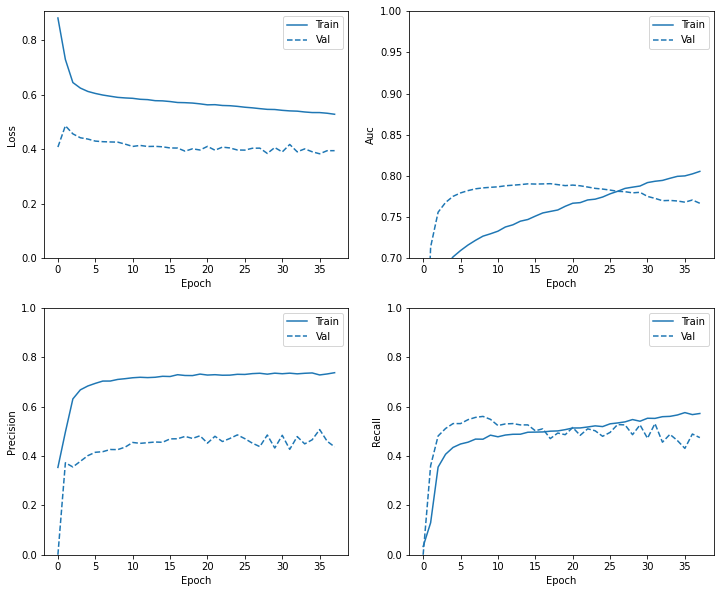

In [ ]:
# modèle élaboré
modele_elab = modele_elabore(X_train = X_train_new_ada, y_train = y_train_new_ada)

loss :  0.3932192027568817
tp :  443.0
fp :  470.0
tn :  6809.0
fn :  516.0
accuracy :  0.8803107738494873
precision :  0.48521357774734497
recall :  0.4619395136833191
auc :  0.7704223990440369
The client correctly predicted not to subscribe to a term deposit (True Negatives):  6809
The client Incorrectly predicted subscribed a term deposit(False Positives):  470
The client mistakenly predicted not subscribed a term deposit (False Negatives):  516
The client correctly predicted subscribed a term deposit(True Positives):  443


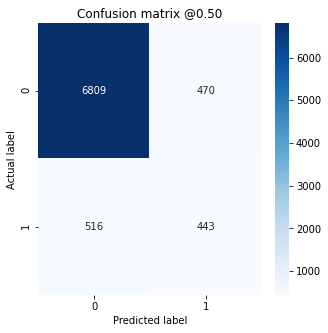

In [ ]:
# Evaluation
model_ela_adasyn_acc,model_ela_adasyn_precision,model_ela_adasyn_recall,model_ela_adasyn_auc  = evaluate_model(modele_elab)

## Interprétation
Après avoir mis en balance notre ensemble de données avec l'approche de Random oversampling, nous pouvons constater ce qui suit :


1.   Erreur constante d'environ 43% pour le modèle élaboré (une légère diminution par rapport à ce que nous avons trouvé avec la baseline de référence d'environ 50%)
2.   Augmentation des rappels (positifs **réels** qui ont été correctement classés) ainsi que l' AUC, car il y a plus de vrais positifs.
3.   Inversement, l'exactitude et la précision sont faibles parce qu'il y a plus de faux positifs.

SMOTE permet d'avoir une bonne accuracy autour de 88% et une dégradation de l'erreur à 0.34 (toujours pour le modèle élaboré). mais il a un impact négatif sur le Recall qui reste toujours moyen.

Pour ADASYN: le Baseline performe lègerement mieux en terme de réduction de l'erreur(0.45 contre 0.39) on peut justifier cela par le fait ou des fuites de données sont produites. Cela signifie que certaines informations du train sont répandu ce qu'est a entrainé une moyenne précision.


# Entrainement avec undersampling

Original dataset shape Counter({0: 23436, 1: 2924})
Resampled dataset shape Counter({0: 5848, 1: 2924})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


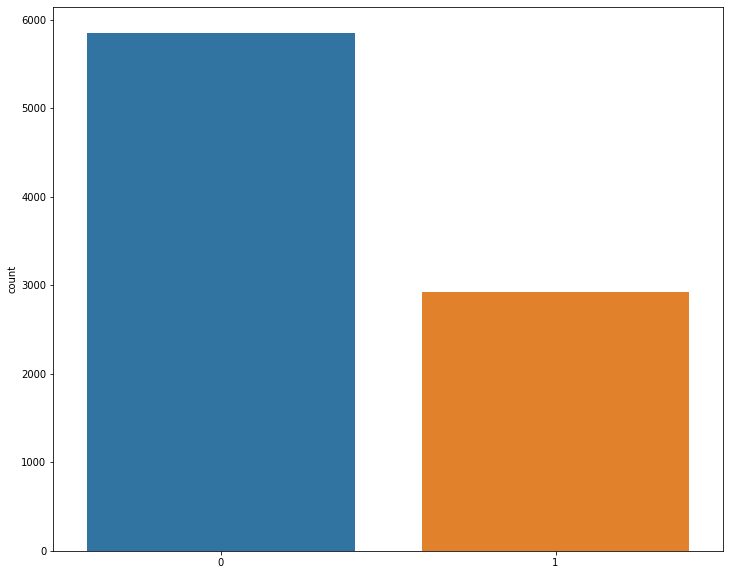

In [ ]:
# Apply Random Undersampling strategy for undersampling:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(0.5)

X_train_new_rus,y_train_new_rus = rus.fit_sample(X_train,y_train)

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_train_new_rus)))
sns.countplot(y_train_new_rus)

## Baseline

Epoch 1/200
5/5 [==============================] - 3s 244ms/step - loss: 0.9614 - tp: 677.3333 - fp: 662.5000 - tn: 10790.3333 - fn: 2365.1667 - accuracy: 0.7952 - precision: 0.5042 - recall: 0.2329 - auc: 0.5036 - val_loss: 0.4057 - val_tp: 27.0000 - val_fp: 63.0000 - val_tn: 5770.0000 - val_fn: 730.0000 - val_accuracy: 0.8797 - val_precision: 0.3000 - val_recall: 0.0357 - val_auc: 0.4523
Epoch 2/200
5/5 [==============================] - 0s 30ms/step - loss: 0.9335 - tp: 249.0000 - fp: 205.0000 - tn: 3977.6667 - fn: 1825.6667 - accuracy: 0.6763 - precision: 0.5460 - recall: 0.1184 - auc: 0.4757 - val_loss: 0.3935 - val_tp: 46.0000 - val_fp: 78.0000 - val_tn: 5755.0000 - val_fn: 711.0000 - val_accuracy: 0.8803 - val_precision: 0.3710 - val_recall: 0.0608 - val_auc: 0.4899
Epoch 3/200
5/5 [==============================] - 0s 28ms/step - loss: 0.8795 - tp: 307.3333 - fp: 228.5000 - tn: 3939.6667 - fn: 1781.8333 - accuracy: 0.6782 - precision: 0.5725 - recall: 0.1484 - auc: 0.5080 - val

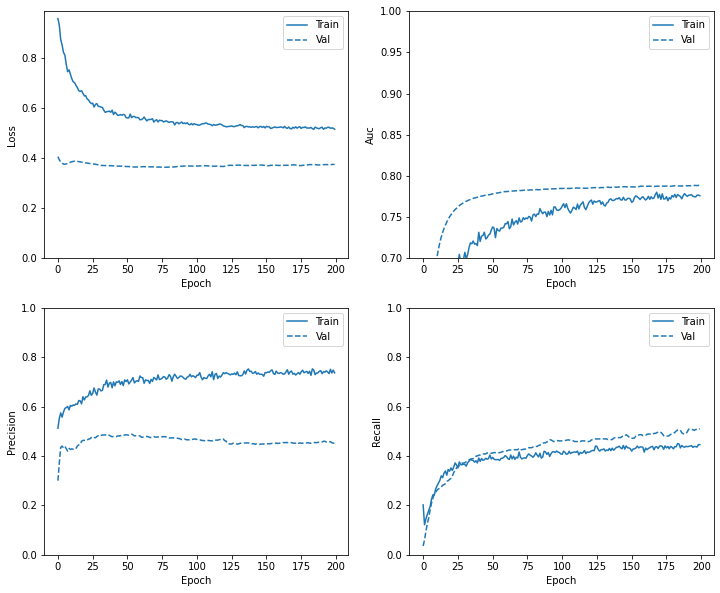

In [ ]:
# Baseline
modele_baseline = basline(X_train = X_train_new_rus, y_train = y_train_new_rus)

loss :  0.3715400695800781
tp :  468.0
fp :  549.0
tn :  6730.0
fn :  491.0
accuracy :  0.8737557530403137
precision :  0.4601770043373108
recall :  0.4880083501338959
auc :  0.7727652192115784
The client correctly predicted not to subscribe to a term deposit (True Negatives):  6730
The client Incorrectly predicted subscribed a term deposit(False Positives):  549
The client mistakenly predicted not subscribed a term deposit (False Negatives):  491
The client correctly predicted subscribed a term deposit(True Positives):  468


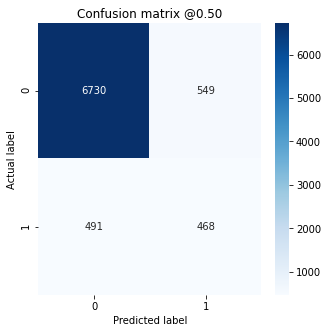

In [ ]:
baseline_random_undersampling_acc,baseline_random_undersampling_precision,baseline_random_undersampling_recall,baseline_random_undersampling_auc  = evaluate_model(modele_baseline)

## Modèle élaboré

Epoch 1/200
5/5 [==============================] - 3s 244ms/step - loss: 0.7906 - tp: 468.0000 - fp: 549.0000 - tn: 10903.8333 - fn: 2574.5000 - accuracy: 0.7887 - precision: 0.4602 - recall: 0.1699 - auc: 0.4193 - val_loss: 0.3636 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5833.0000 - val_fn: 757.0000 - val_accuracy: 0.8851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4073
Epoch 2/200
5/5 [==============================] - 0s 31ms/step - loss: 0.7649 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4182.6667 - fn: 2074.6667 - accuracy: 0.6696 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4492 - val_loss: 0.3661 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5833.0000 - val_fn: 757.0000 - val_accuracy: 0.8851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4458
Epoch 3/200
5/5 [==============================] - 0s 32ms/step - loss: 0.7474 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4168.1667 - fn: 2089.1667 - accuracy: 0.6657 - precision:

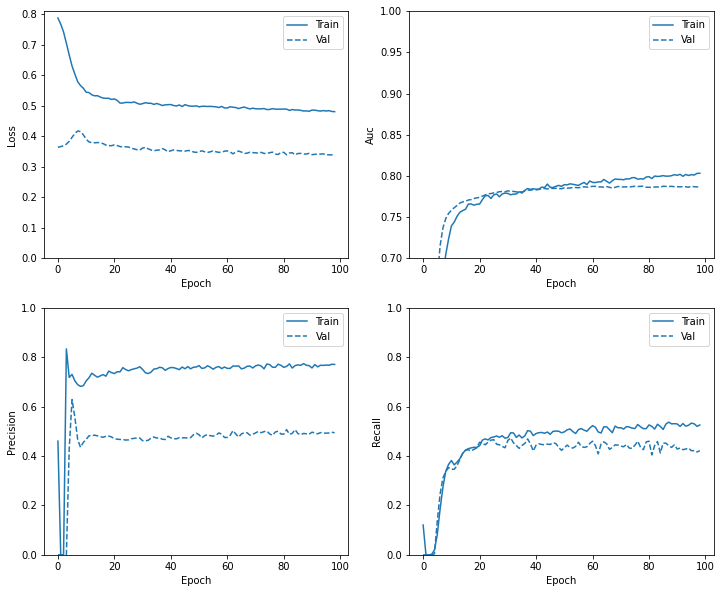

In [ ]:
# modèle élaboré
modele_elab = modele_elabore(X_train = X_train_new_rus, y_train = y_train_new_rus)

loss :  0.34077945351600647
tp :  388.0
fp :  364.0
tn :  6915.0
fn :  571.0
accuracy :  0.8865015506744385
precision :  0.5159574747085571
recall :  0.40458810329437256
auc :  0.7738970518112183
The client correctly predicted not to subscribe to a term deposit (True Negatives):  6915
The client Incorrectly predicted subscribed a term deposit(False Positives):  364
The client mistakenly predicted not subscribed a term deposit (False Negatives):  571
The client correctly predicted subscribed a term deposit(True Positives):  388


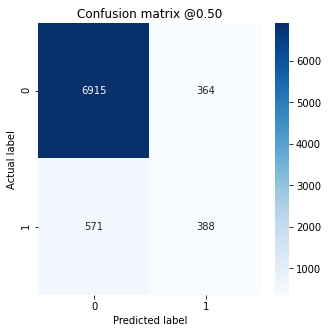

In [ ]:
# Evaluation
model_ela_random_undersampling_acc,model_ela_random_undersampling_precision,model_ela_random_undersampling_recall,model_ela_random_undersampling_auc  = evaluate_model(modele_elab)

Avec Undersampling:
1.   Nous constatons une stabilité entre le Recall et la précision avec une rédection des faux négatifs (moins de call pour les clients)
2.   Par rapport au temps d'entrainement les deux modèles (ont pris un temps plus que le oversampling).

## Tomek links

In [ ]:
# Apply Random Undersampling strategy for undersampling:
from imblearn.under_sampling import TomekLinks

tm = TomekLinks(sampling_strategy='auto')
X_train_new_tm,y_train_new_tm = tm.fit_sample(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Baseline

Epoch 1/200
13/13 [==============================] - 3s 85ms/step - loss: 0.4799 - tp: 577.7857 - fp: 916.5714 - tn: 19471.3571 - fn: 2076.5714 - accuracy: 0.8710 - precision: 0.3952 - recall: 0.2325 - auc: 0.5849 - val_loss: 0.3827 - val_tp: 27.0000 - val_fp: 46.0000 - val_tn: 5787.0000 - val_fn: 730.0000 - val_accuracy: 0.8822 - val_precision: 0.3699 - val_recall: 0.0357 - val_auc: 0.4924
Epoch 2/200
13/13 [==============================] - 0s 15ms/step - loss: 0.4421 - tp: 211.8571 - fp: 404.2143 - tn: 12697.7857 - fn: 1490.4286 - accuracy: 0.8712 - precision: 0.3392 - recall: 0.1252 - auc: 0.5155 - val_loss: 0.3565 - val_tp: 56.0000 - val_fp: 45.0000 - val_tn: 5788.0000 - val_fn: 701.0000 - val_accuracy: 0.8868 - val_precision: 0.5545 - val_recall: 0.0740 - val_auc: 0.5679
Epoch 3/200
13/13 [==============================] - 0s 14ms/step - loss: 0.4178 - tp: 207.1429 - fp: 360.7143 - tn: 12742.7143 - fn: 1493.7143 - accuracy: 0.8741 - precision: 0.3651 - recall: 0.1239 - auc: 0.543

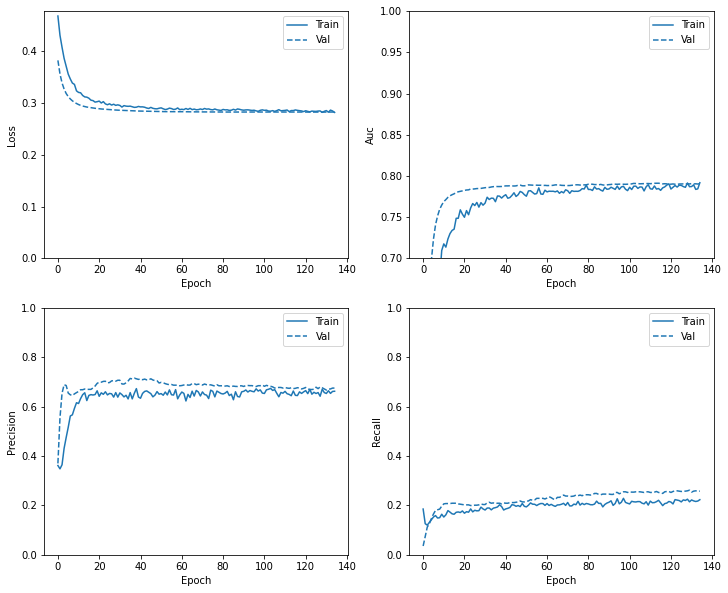

In [ ]:
# Baseline
modele_baseline = basline(X_train = X_train_new_tm, y_train = y_train_new_tm)

loss :  0.28740498423576355
tp :  223.0
fp :  101.0
tn :  7178.0
fn :  736.0
accuracy :  0.89839768409729
precision :  0.6882715821266174
recall :  0.23253388702869415
auc :  0.7755436897277832
The client correctly predicted not to subscribe to a term deposit (True Negatives):  7178
The client Incorrectly predicted subscribed a term deposit(False Positives):  101
The client mistakenly predicted not subscribed a term deposit (False Negatives):  736
The client correctly predicted subscribed a term deposit(True Positives):  223


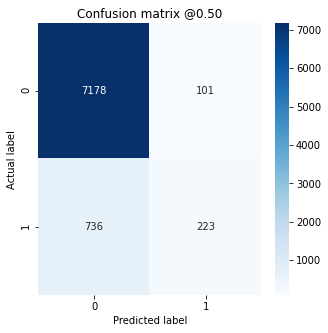

In [ ]:
baseline_tomek_links_acc,baseline_tomek_links_precision,baseline_tomek_links_recall,baseline_tomek_links_auc  = evaluate_model(modele_baseline)

## Modèle élaboré

Epoch 1/200
13/13 [==============================] - 3s 122ms/step - loss: 0.3599 - tp: 223.0000 - fp: 101.0000 - tn: 20286.9286 - fn: 2431.3571 - accuracy: 0.8907 - precision: 0.6883 - recall: 0.0962 - auc: 0.6467 - val_loss: 0.3529 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5833.0000 - val_fn: 757.0000 - val_accuracy: 0.8851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6514
Epoch 2/200
13/13 [==============================] - 0s 19ms/step - loss: 0.3514 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 13102.0000 - fn: 1702.2857 - accuracy: 0.8850 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6307 - val_loss: 0.3434 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5833.0000 - val_fn: 757.0000 - val_accuracy: 0.8851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7179
Epoch 3/200
13/13 [==============================] - 0s 17ms/step - loss: 0.3406 - tp: 0.7143 - fp: 1.0000 - tn: 13102.4286 - fn: 1700.1429 - accuracy: 0.8847 - precision:

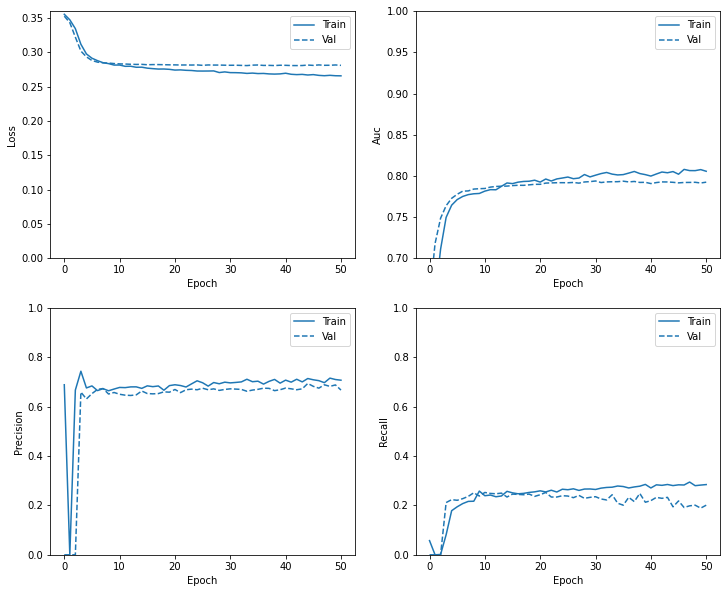

In [ ]:
# modèle élaboré
modele_elab = modele_elabore(X_train = X_train_new_tm, y_train = y_train_new_tm)

loss :  0.28825584053993225
tp :  194.0
fp :  87.0
tn :  7192.0
fn :  765.0
accuracy :  0.8965768218040466
precision :  0.690391480922699
recall :  0.20229405164718628
auc :  0.7734619379043579
The client correctly predicted not to subscribe to a term deposit (True Negatives):  7192
The client Incorrectly predicted subscribed a term deposit(False Positives):  87
The client mistakenly predicted not subscribed a term deposit (False Negatives):  765
The client correctly predicted subscribed a term deposit(True Positives):  194


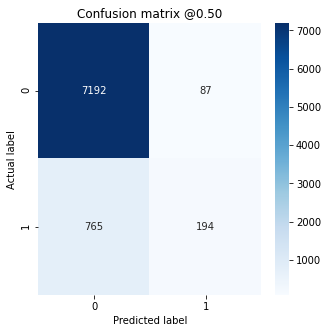

In [ ]:
# Evaluation
model_ela_tomek_links_acc,model_ela_tomek_links_precision,model_ela_tomek_links_recall,model_ela_tomek_links_auc  = evaluate_model(modele_elab)

## Interprétation

Avec Undersampling:

1.   Nous constatons une stabilité entre le rappel et la précision avec une réduction des faux négatifs (moins d'appel pour les clients).
2.   Par rapport au temps d'entrainement, les deux modèles (ont pris plus de temps que le le oversampling).

TOMEK LINKS nous a permis de :
1.   de réduire de façon intéressante l'erreur de classification à 0.28 (la meilleure jusqu'à présent).
2.   D'avoir une très bonne précision d'environ 90% sur les données de test et une bonne précision,
3.   D'autre part, un faible rappel (pour les deux modèles).

Bien que, dans ce cas, notre modèle soit très précis (par rapport à l'oversampling et la pondération), si nous sommes intéressés par les clients potentiels que nous pouvons contacter lors des prochaines campagnes avec la certitude que ce client souscrit à un dépôt à terme, sans trop déranger les autres clients, ce modèle présente un compromis entre ces différents types d'ascpects.

# Entrainement avec une approche hybrid de resampling

## Random oversampling + Tomek links

In [ ]:
#Appliquer Oversampling
ros =  RandomOverSampler()
X_train_new,y_train_new = ros.fit_sample(X_train,y_train)

# Appliquer TomekLinks
tm = TomekLinks()
X_train_hyb,y_train_hyb = tm.fit_resample(X_train_new,y_train_new)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Baseline

Epoch 1/200
24/24 [==============================] - 3s 65ms/step - loss: 1.2744 - tp: 1898.9600 - fp: 826.9600 - tn: 19377.2400 - fn: 11964.6000 - accuracy: 0.6470 - precision: 0.6956 - recall: 0.1346 - auc: 0.5780 - val_loss: 0.3900 - val_tp: 115.0000 - val_fp: 158.0000 - val_tn: 5675.0000 - val_fn: 642.0000 - val_accuracy: 0.8786 - val_precision: 0.4212 - val_recall: 0.1519 - val_auc: 0.5757
Epoch 2/200
24/24 [==============================] - 0s 12ms/step - loss: 1.0157 - tp: 3009.0800 - fp: 1270.8400 - tn: 11635.7200 - fn: 9914.1200 - accuracy: 0.5643 - precision: 0.7021 - recall: 0.2242 - auc: 0.5569 - val_loss: 0.4221 - val_tp: 205.0000 - val_fp: 409.0000 - val_tn: 5424.0000 - val_fn: 552.0000 - val_accuracy: 0.8542 - val_precision: 0.3339 - val_recall: 0.2708 - val_auc: 0.6721
Epoch 3/200
24/24 [==============================] - 0s 11ms/step - loss: 0.8627 - tp: 4364.4400 - fp: 1830.2800 - tn: 11126.2000 - fn: 8508.8400 - accuracy: 0.5994 - precision: 0.7050 - recall: 0.3339 - 

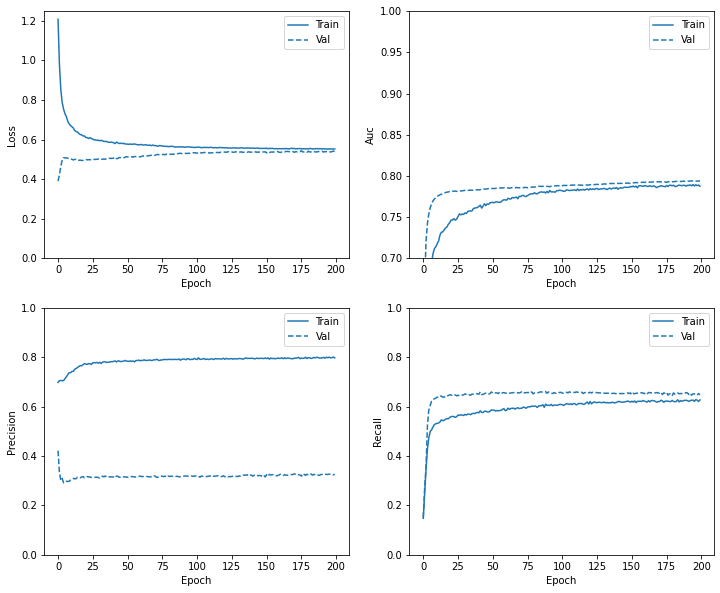

In [ ]:
# Baseline
modele_baseline = basline(X_train = X_train_hyb, y_train = y_train_hyb)

loss :  0.5291345119476318
tp :  595.0
fp :  1190.0
tn :  6089.0
fn :  364.0
accuracy :  0.8113619685173035
precision :  0.3333333432674408
recall :  0.6204379796981812
auc :  0.7801693081855774
The client correctly predicted not to subscribe to a term deposit (True Negatives):  6089
The client Incorrectly predicted subscribed a term deposit(False Positives):  1190
The client mistakenly predicted not subscribed a term deposit (False Negatives):  364
The client correctly predicted subscribed a term deposit(True Positives):  595


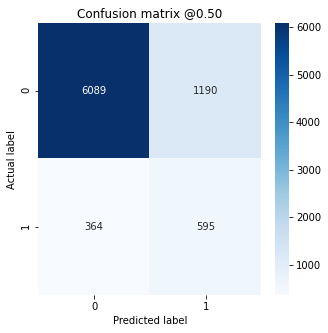

In [ ]:
baseline_random_over_tomeklinks_acc,baseline_random_over_tomeklinks_precision,baseline_random_over_tomeklinks_recall,baseline_random_over_tomeklinks_auc  = evaluate_model(modele_baseline)

## Modèle Élaboré

Epoch 1/200
24/24 [==============================] - 3s 51ms/step - loss: 1.0656 - tp: 630.4400 - fp: 1254.4000 - tn: 18949.8000 - fn: 13233.1200 - accuracy: 0.5953 - precision: 0.3343 - recall: 0.0704 - auc: 0.3419 - val_loss: 0.4424 - val_tp: 3.0000 - val_fp: 35.0000 - val_tn: 5798.0000 - val_fn: 754.0000 - val_accuracy: 0.8803 - val_precision: 0.0789 - val_recall: 0.0040 - val_auc: 0.5088
Epoch 2/200
24/24 [==============================] - 0s 15ms/step - loss: 0.7668 - tp: 3766.8800 - fp: 2487.0000 - tn: 10419.5600 - fn: 9156.3200 - accuracy: 0.5365 - precision: 0.5784 - recall: 0.2402 - auc: 0.5494 - val_loss: 0.5663 - val_tp: 431.0000 - val_fp: 1133.0000 - val_tn: 4700.0000 - val_fn: 326.0000 - val_accuracy: 0.7786 - val_precision: 0.2756 - val_recall: 0.5694 - val_auc: 0.7395
Epoch 3/200
24/24 [==============================] - 0s 15ms/step - loss: 0.6184 - tp: 7323.3600 - fp: 2848.0400 - tn: 10108.4400 - fn: 5549.9200 - accuracy: 0.6718 - precision: 0.7123 - recall: 0.5706 - au

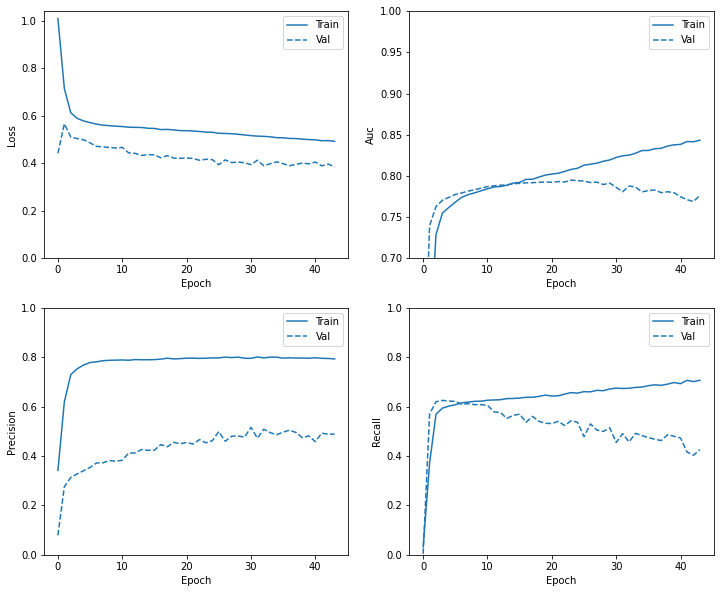

In [ ]:
# modèle élaboré
modele_elab = modele_elabore(X_train = X_train_hyb, y_train = y_train_hyb)

loss :  0.4133312404155731
tp :  503.0
fp :  594.0
tn :  6685.0
fn :  456.0
accuracy :  0.8725419044494629
precision :  0.4585232436656952
recall :  0.5245047211647034
auc :  0.7815815210342407
The client correctly predicted not to subscribe to a term deposit (True Negatives):  6685
The client Incorrectly predicted subscribed a term deposit(False Positives):  594
The client mistakenly predicted not subscribed a term deposit (False Negatives):  456
The client correctly predicted subscribed a term deposit(True Positives):  503


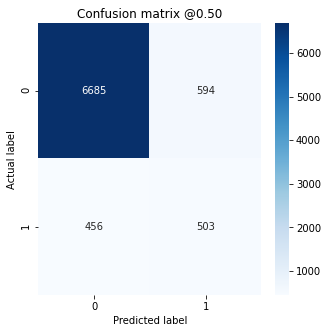

In [ ]:
# Evaluation
model_ela_random_over_tomeklinks_acc,model_ela_random_over_tomeklinks_precision,model_ela_random_over_tomeklinks_recall,model_ela_random_over_tomeklinks_auc  = evaluate_model(modele_elab)

La conjuction de Random oversampling et Tomek link:
avec l'approche hybride nous tendons vers une augmentation des faux postifis( ce qu'est critiques pour en vue d'augmenter le benefice lors des prochains compaigns)
d'un coté, une précision moyenne avec le modèle élaboré et en dessous de la moyenne avec le baseline, donc imputation des classes avec les deux approches n'a pas servi à grand chose.
d'autre part, le Recall (pouvoir detecter réellement positif) est légerment supérieure à la moyenne pour les deux modèle avec une légère augmentationavec le baseline pa rapport au moèle élaboré.
Ceci peut s'expliquer par le fait qu'il y avait une fuite des données, ou nous pôurrons penser que le Random oversampling au début à écarter des données potentiellement utiles dans la classe non qui pourraient être importantes pour le processus d'induction et par conséquent sur la performance de notre modèle. 



## SMOTE + Tomek links Manuellement

In [ ]:
#Appliquer SMOTE
sm = SMOTE(0.5)
X_train_new_smote,y_train_new_smote =sm.fit_sample(X_train,y_train)

# Appliquer TomekLinks
tm = TomekLinks()
X_train_hyb,y_train_hyb = tm.fit_resample(X_train_new_smote,y_train_new_smote)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/200
18/18 [==============================] - 3s 62ms/step - loss: 0.9423 - tp: 1296.7895 - fp: 1263.8947 - tn: 19163.4737 - fn: 6283.8421 - accuracy: 0.7423 - precision: 0.5010 - recall: 0.1897 - auc: 0.4713 - val_loss: 0.3813 - val_tp: 85.0000 - val_fp: 108.0000 - val_tn: 5725.0000 - val_fn: 672.0000 - val_accuracy: 0.8816 - val_precision: 0.4404 - val_recall: 0.1123 - val_auc: 0.5471
Epoch 2/200
18/18 [==============================] - 0s 13ms/step - loss: 0.8237 - tp: 1237.1053 - fp: 885.5789 - tn: 12227.6842 - fn: 5419.6316 - accuracy: 0.6799 - precision: 0.5784 - recall: 0.1789 - auc: 0.5426 - val_loss: 0.3783 - val_tp: 163.0000 - val_fp: 216.0000 - val_tn: 5617.0000 - val_fn: 594.0000 - val_accuracy: 0.8771 - val_precision: 0.4301 - val_recall: 0.2153 - val_auc: 0.6446
Epoch 3/200
18/18 [==============================] - 0s 13ms/step - loss: 0.7525 - tp: 1664.6842 - fp: 1146.5789 - tn: 11933.7368 - fn: 5025.0000 - accuracy: 0.6873 - precision: 0.5917 - recall: 0.2444 - au

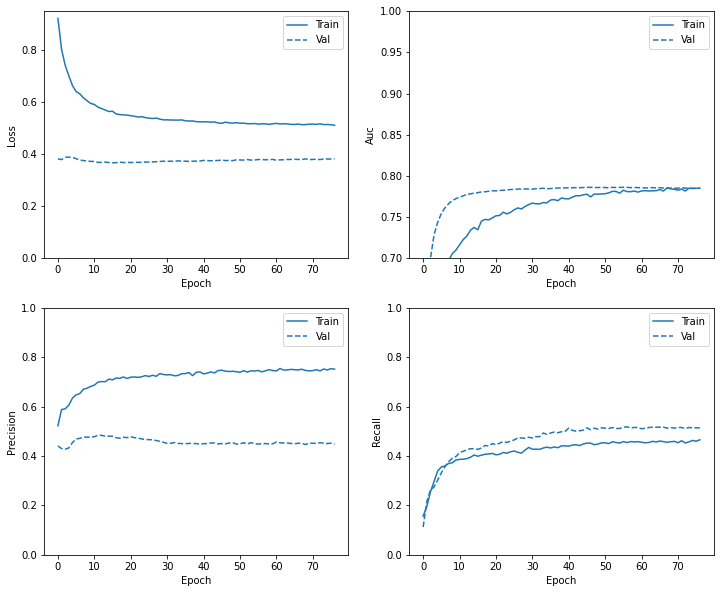

In [ ]:
# Baseline
modele_baseline = basline(X_train = X_train_hyb, y_train = y_train_hyb)

loss :  0.374727725982666
tp :  478.0
fp :  569.0
tn :  6710.0
fn :  481.0
accuracy :  0.8725419044494629
precision :  0.4565424919128418
recall :  0.4984358847141266
auc :  0.7699821591377258
The client correctly predicted not to subscribe to a term deposit (True Negatives):  6710
The client Incorrectly predicted subscribed a term deposit(False Positives):  569
The client mistakenly predicted not subscribed a term deposit (False Negatives):  481
The client correctly predicted subscribed a term deposit(True Positives):  478


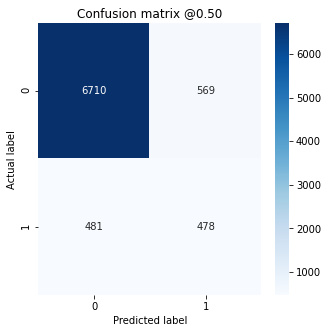

In [ ]:
baseline_smote_tomeklinks_acc,baseline_smote_tomeklinks_precision,baseline_smote_tomeklinks_recall,baseline_smote_tomeklinks_auc  = evaluate_model(modele_baseline)

## Modèle Élaboré

Epoch 1/200
18/18 [==============================] - 3s 65ms/step - loss: 0.7804 - tp: 478.0000 - fp: 569.1053 - tn: 19858.2632 - fn: 7102.6316 - accuracy: 0.7385 - precision: 0.4565 - recall: 0.0890 - auc: 0.4166 - val_loss: 0.3731 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5833.0000 - val_fn: 757.0000 - val_accuracy: 0.8851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5373
Epoch 2/200
18/18 [==============================] - 0s 16ms/step - loss: 0.6702 - tp: 353.2105 - fp: 124.5263 - tn: 12988.7368 - fn: 6303.5263 - accuracy: 0.6715 - precision: 0.6920 - recall: 0.0369 - auc: 0.5535 - val_loss: 0.4153 - val_tp: 206.0000 - val_fp: 204.0000 - val_tn: 5629.0000 - val_fn: 551.0000 - val_accuracy: 0.8854 - val_precision: 0.5024 - val_recall: 0.2721 - val_auc: 0.7235
Epoch 3/200
18/18 [==============================] - 0s 14ms/step - loss: 0.5719 - tp: 2275.0526 - fp: 1069.7368 - tn: 12010.5789 - fn: 4414.6316 - accuracy: 0.7209 - precision: 0.6834 - recall: 0

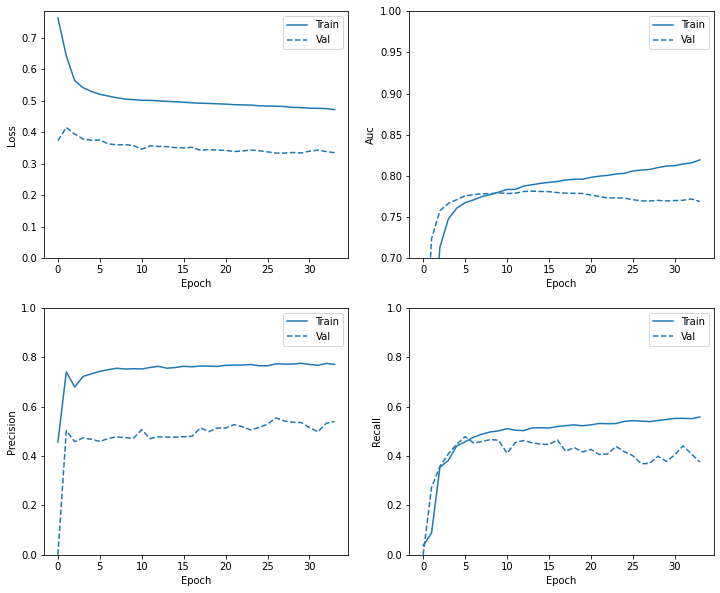

In [ ]:
# modèle élaboré
modele_elab = modele_elabore(X_train = X_train_hyb, y_train = y_train_hyb)

loss :  0.35343828797340393
tp :  441.0
fp :  462.0
tn :  6817.0
fn :  518.0
accuracy :  0.8810390830039978
precision :  0.4883720874786377
recall :  0.45985400676727295
auc :  0.7656989097595215
The client correctly predicted not to subscribe to a term deposit (True Negatives):  6817
The client Incorrectly predicted subscribed a term deposit(False Positives):  462
The client mistakenly predicted not subscribed a term deposit (False Negatives):  518
The client correctly predicted subscribed a term deposit(True Positives):  441


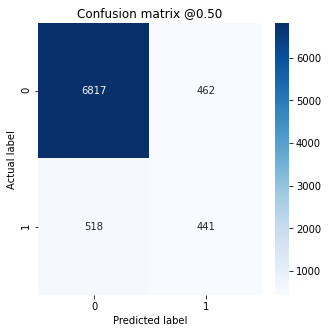

In [ ]:
# Evaluation
model_ela_smote_tomeklinks_acc,model_ela_smote_tomeklinks_precision,model_ela_smote_tomeklinks_recall,model_ela_smote_tomeklinks_auc  = evaluate_model(modele_elab)

## SMOTE + Tomek links via SMOTETomek

In [ ]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(0.5)
X_train_new_smt,y_train_new_smt =smt.fit_sample(X_train,y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Baseline

Epoch 1/200
18/18 [==============================] - 3s 61ms/step - loss: 0.9562 - tp: 1215.9474 - fp: 1125.8421 - tn: 19341.6316 - fn: 6288.8947 - accuracy: 0.7470 - precision: 0.5145 - recall: 0.1775 - auc: 0.4976 - val_loss: 0.3808 - val_tp: 86.0000 - val_fp: 106.0000 - val_tn: 5727.0000 - val_fn: 671.0000 - val_accuracy: 0.8821 - val_precision: 0.4479 - val_recall: 0.1136 - val_auc: 0.5481
Epoch 2/200
18/18 [==============================] - 0s 12ms/step - loss: 0.8160 - tp: 1222.6316 - fp: 875.1053 - tn: 12314.0000 - fn: 5322.5789 - accuracy: 0.6858 - precision: 0.5850 - recall: 0.1820 - auc: 0.5405 - val_loss: 0.3763 - val_tp: 160.0000 - val_fp: 212.0000 - val_tn: 5621.0000 - val_fn: 597.0000 - val_accuracy: 0.8772 - val_precision: 0.4301 - val_recall: 0.2114 - val_auc: 0.6440
Epoch 3/200
18/18 [==============================] - 0s 12ms/step - loss: 0.7406 - tp: 1583.6842 - fp: 1085.5789 - tn: 12128.3158 - fn: 4936.7368 - accuracy: 0.6936 - precision: 0.5936 - recall: 0.2394 - au

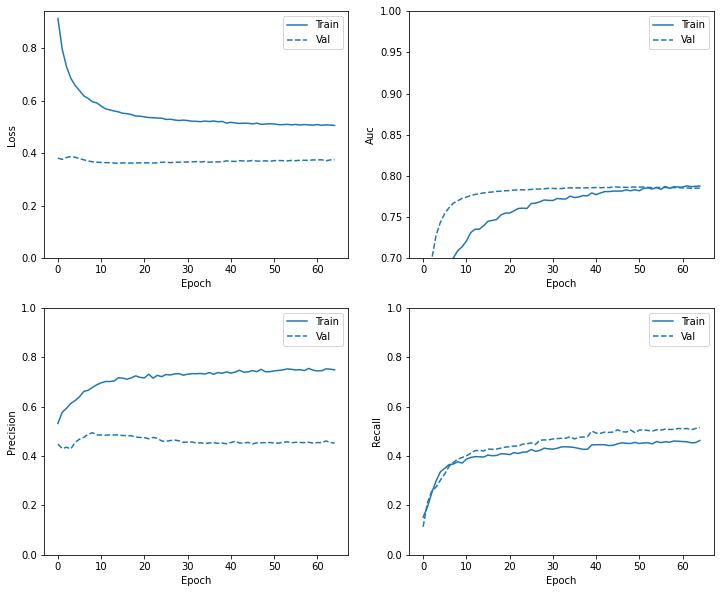

In [ ]:
# Baseline
modele_baseline = basline(X_train = X_train_new_smt, y_train = y_train_new_smt)

loss :  0.36552518606185913
tp :  464.0
fp :  525.0
tn :  6754.0
fn :  495.0
accuracy :  0.8761835694313049
precision :  0.4691607654094696
recall :  0.4838373363018036
auc :  0.7706459760665894
The client correctly predicted not to subscribe to a term deposit (True Negatives):  6754
The client Incorrectly predicted subscribed a term deposit(False Positives):  525
The client mistakenly predicted not subscribed a term deposit (False Negatives):  495
The client correctly predicted subscribed a term deposit(True Positives):  464


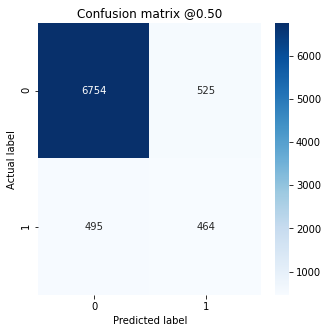

In [ ]:
baseline_smote_tomeklinks_acc,baseline_smote_tomeklinks_precision,baseline_smote_tomeklinks_recall,baseline_smote_tomeklinks_auc  = evaluate_model(modele_baseline)

## Modèle Élaboré

Epoch 1/200
18/18 [==============================] - 3s 64ms/step - loss: 0.7732 - tp: 464.0000 - fp: 525.2105 - tn: 19942.2632 - fn: 7040.8421 - accuracy: 0.7420 - precision: 0.4691 - recall: 0.0874 - auc: 0.4306 - val_loss: 0.3717 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 5833.0000 - val_fn: 757.0000 - val_accuracy: 0.8851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5459
Epoch 2/200
18/18 [==============================] - 0s 16ms/step - loss: 0.6632 - tp: 344.4737 - fp: 117.5263 - tn: 13071.5789 - fn: 6200.7368 - accuracy: 0.6764 - precision: 0.7559 - recall: 0.0367 - auc: 0.5611 - val_loss: 0.4080 - val_tp: 196.0000 - val_fp: 176.0000 - val_tn: 5657.0000 - val_fn: 561.0000 - val_accuracy: 0.8882 - val_precision: 0.5269 - val_recall: 0.2589 - val_auc: 0.7227
Epoch 3/200
18/18 [==============================] - 0s 16ms/step - loss: 0.5673 - tp: 2102.8421 - fp: 928.3158 - tn: 12285.5789 - fn: 4417.5789 - accuracy: 0.7262 - precision: 0.6956 - recall: 0.

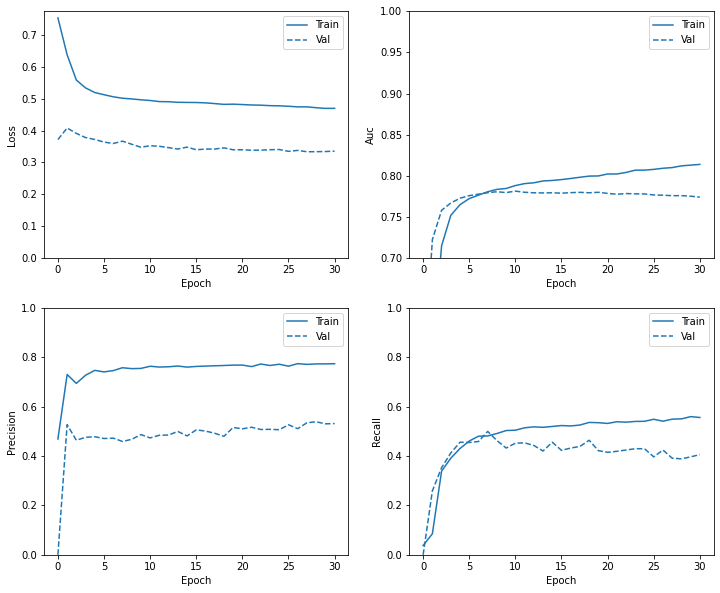

In [ ]:
# modèle élaboré
modele_elab = modele_elabore(X_train = X_train_new_smt, y_train = y_train_new_smt)

loss :  0.35099709033966064
tp :  439.0
fp :  461.0
tn :  6818.0
fn :  520.0
accuracy :  0.8809177279472351
precision :  0.4877777695655823
recall :  0.4577684998512268
auc :  0.7684781551361084
The client correctly predicted not to subscribe to a term deposit (True Negatives):  6818
The client Incorrectly predicted subscribed a term deposit(False Positives):  461
The client mistakenly predicted not subscribed a term deposit (False Negatives):  520
The client correctly predicted subscribed a term deposit(True Positives):  439


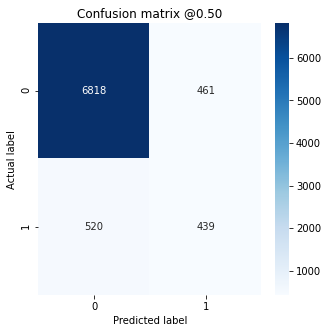

In [ ]:
# Evaluation
model_ela_smote_tomeklinks_acc,model_ela_smote_tomeklinks_precision,model_ela_smote_tomeklinks_recall,model_ela_smote_tomeklinks_auc  = evaluate_model(modele_elab)

## Interprétation

Nous pourrons dire dans ce cas que 
la méthode SMOTE est d'abord appliquée pour oversampling la classe minoritaire (yes) afin d'obtenir une distribution équilibrée, puis des données dans Tomek Links provenant de la  classe majoritaire sont identifiées et supprimées.
et donc seuls les échantillons de la classe majoritaire qui participent du Tomek Links ont été supprimés, car les autres échantillons de la classe minoritaire étaient considérés comme trop rares pour être écartés.
Cette combinaison permet une réduction des faux négatifs au prix d'une augmentation des faux positif. En revanche cette derniere nous a donnée une précision et un Recall moyen.

# Conclusions générales

## Analyser les modèles

In [ ]:
df_results = pd.DataFrame({'modele':['baseline','baseline','baseline','baseline','baseline','baseline','baseline','baseline','baseline','modèle_élaboré','modèle_élaboré','modèle_élaboré','modèle_élaboré','modèle_élaboré','modèle_élaboré','modèle_élaboré','modèle_élaboré','modèle_élaboré'],
                           'methode':['simple','ponderation_class','random_oversampling','smote','adasyn','random_undersampling','tomek_links','random_over_tomeklinks','smote_tomeklinks']*2,

                          'accuracy':[baseline_simple_acc,baseline_pond_acc ,baseline_random_oversampling_acc,baseline_smote_acc,baseline_adasyn_acc,baseline_random_undersampling_acc,baseline_tomek_links_acc, baseline_random_over_tomeklinks_acc,baseline_smote_tomeklinks_acc,model_ela_simple_acc,model_ela_pond_acc ,model_ela_random_oversampling_acc,model_ela_smote_acc,model_ela_adasyn_acc,model_ela_random_undersampling_acc,model_ela_tomek_links_acc, model_ela_random_over_tomeklinks_acc,model_ela_smote_tomeklinks_acc,],
                          'recall':[baseline_simple_recall,baseline_pond_recall ,baseline_random_oversampling_recall,baseline_smote_recall,baseline_adasyn_recall,baseline_random_undersampling_recall,baseline_tomek_links_recall, baseline_random_over_tomeklinks_recall,baseline_smote_tomeklinks_recall,model_ela_simple_recall,model_ela_pond_recall ,model_ela_random_oversampling_recall,model_ela_smote_recall,model_ela_adasyn_recall,model_ela_random_undersampling_recall,model_ela_tomek_links_recall, model_ela_random_over_tomeklinks_recall,model_ela_smote_tomeklinks_recall,],
                          'precision':[baseline_simple_precision,baseline_pond_precision ,baseline_random_oversampling_precision,baseline_smote_precision,baseline_adasyn_precision,baseline_random_undersampling_precision,baseline_tomek_links_precision, baseline_random_over_tomeklinks_precision,baseline_smote_tomeklinks_precision,model_ela_simple_precision,model_ela_pond_precision ,model_ela_random_oversampling_precision,model_ela_smote_precision,model_ela_adasyn_precision,model_ela_random_undersampling_precision,model_ela_tomek_links_precision, model_ela_random_over_tomeklinks_precision,model_ela_smote_tomeklinks_precision,],
                          'auc':[baseline_simple_auc,baseline_pond_auc ,baseline_random_oversampling_auc,baseline_smote_auc,baseline_adasyn_auc,baseline_random_undersampling_auc,baseline_tomek_links_auc, baseline_random_over_tomeklinks_auc,baseline_smote_tomeklinks_auc,model_ela_simple_auc,model_ela_pond_auc ,model_ela_random_oversampling_auc,model_ela_smote_auc,model_ela_adasyn_auc ,model_ela_random_undersampling_auc ,model_ela_tomek_links_auc, model_ela_random_over_tomeklinks_auc,model_ela_smote_tomeklinks_auc,],
                          
                          })


In [ ]:
df_results

,modele,methode,accuracy,recall,precision,auc
0,baseline,simple,0.897669,0.190824,0.732000,0.776287
1,baseline,ponderation_class,0.805050,0.617310,0.323321,0.772390
2,baseline,random_oversampling,0.811362,0.620438,0.333333,0.780169
3,baseline,smote,0.875334,0.486966,0.466068,0.771615
4,baseline,adasyn,0.833333,0.572471,0.363095,0.768230
5,baseline,random_undersampling,0.873756,0.488008,0.460177,0.772765
6,baseline,tomek_links,0.898398,0.232534,0.688272,0.775544
7,baseline,random_over_tomeklinks,0.811362,0.620438,0.333333,0.780169
8,baseline,smote_tomeklinks,0.876184,0.483837,0.469161,0.770646
9,modèle_élaboré,simple,0.892328,0.119917,0.727848,0.773537


In [ ]:
def plot_results(metric):
  ax = sns.barplot(x="modele", y=str(metric), hue="methode", data=df_results)
  ax.set_xlabel('Modèle',fontsize = 15)
  ax.set_ylabel(metric.capitalize(), fontsize = 15)
  ax.tick_params(labelsize=15)

  # Put the legend out of the figure
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
  plt.title(metric.capitalize())
  plt.show()

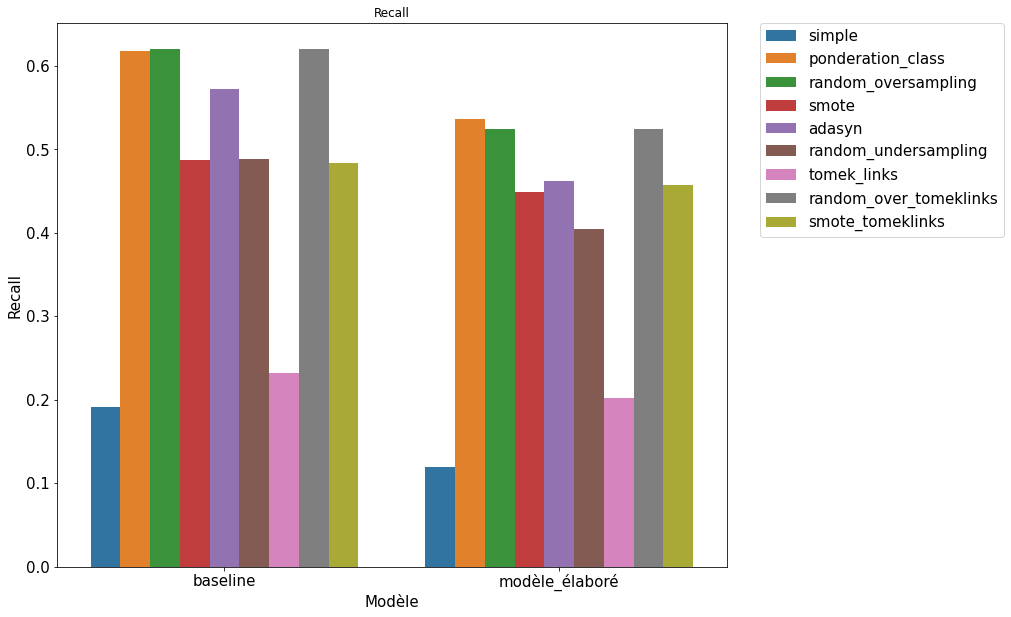

In [ ]:
# Recall
plot_results('recall')

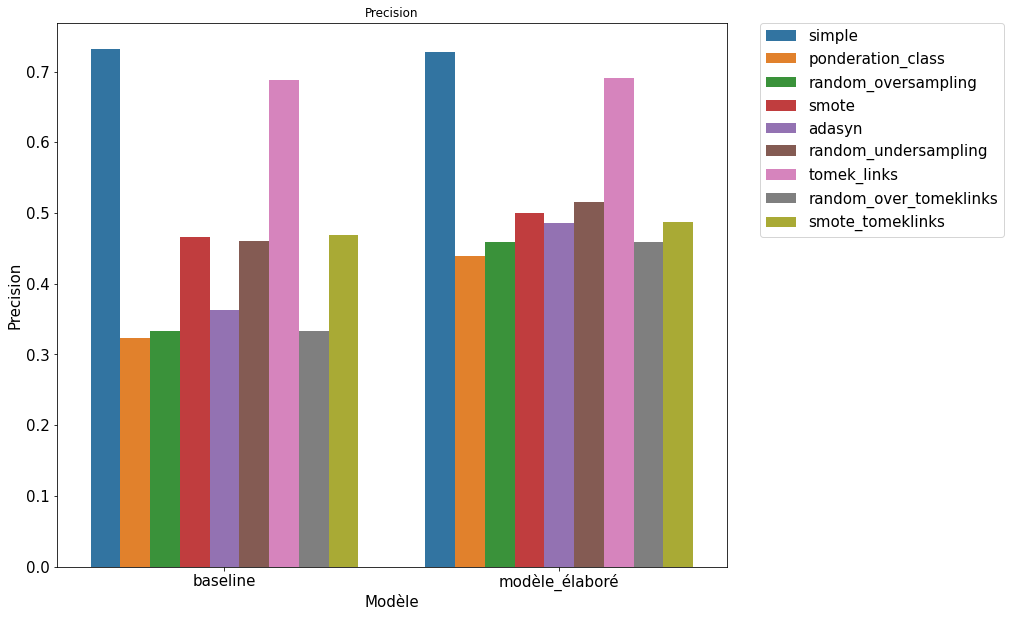

In [ ]:
# precision
plot_results('precision')

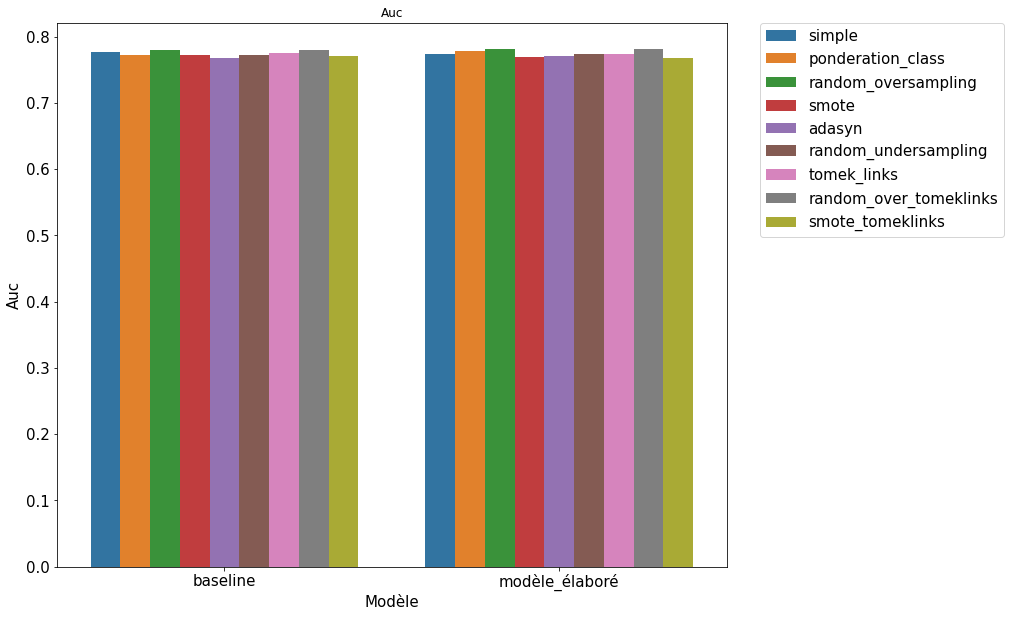

In [ ]:
# auc
plot_results('auc')

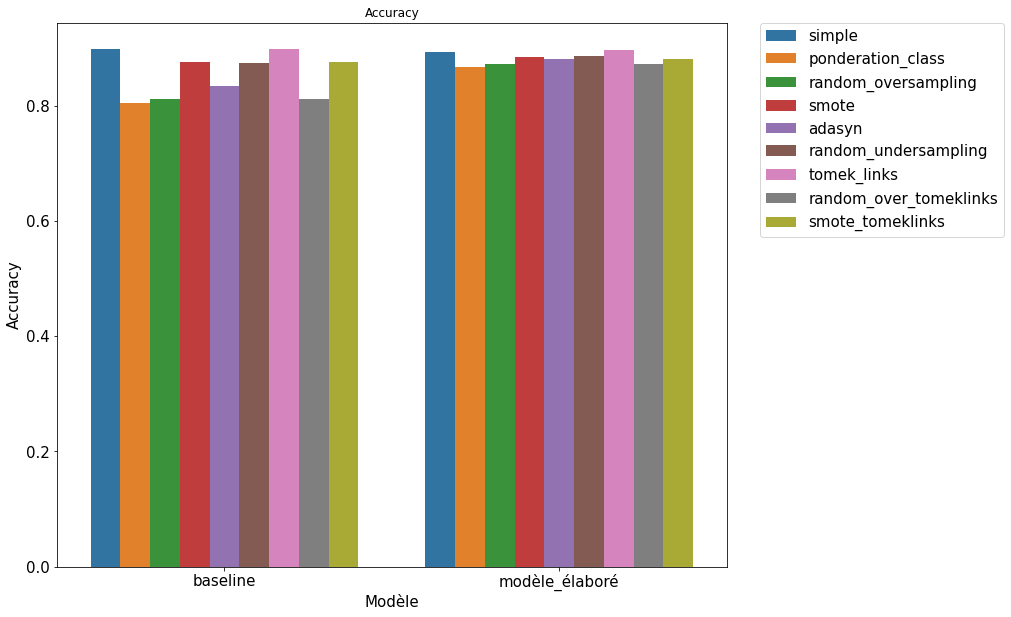

In [ ]:
# accuracy
plot_results('accuracy')

**En ce qui concerne les variables** :

- Les deux facteurs les plus importants dans la décision du client sont l'âge et le taux interbancaire offert en euros (Euribor).
- 65% des anciens clients ont souscrit le nouveau dépôt à terme.

**En ce qui concerne les modèles avec des agréments différents** :

- Nous avons deux cas avec les tracés des résultats :
1. On constate que le baseline permet d'avoir un bon rappel, alors que le modèle élaboré permet une bonne précision, ceci sur l'ensemble des approches proposées.

2. L'entrainement  de nos modèles (baseline et élaboré) avec Tomek Links a donné la meilleure précision ainsi ainsi que l'entrainement simple, de sorte que nous pouvons juger que nos opérations de base avaient un impact positif sur les résultats après avoir supprimé la durée et la compagne.

3. Les deux méthodes hybrides de Random oversampling et SMOTE avec Tomek Links, à l'exception des neuf méthodes discutées, donnent un bon compromis entre précision et rappel.


**Remarque :**
Si nous souhaitons avoir de nouveaux clients pour les prochaines compagnes sans pour autant déranger nos propres clients à souscrire un dépôt à terme, nous proposons le modèle entrainer en appliquant les méthodes hybrides (en préférant moyennant SMOTE avec Tomek Links).

